In [1]:
!pip install seaborn
!pip install scikit-learn
!pip install folium
!pip install  graphviz
!pip install econml
!pip install plotly-geo==1.0.0
!pip install geopandas==0.8.1
!pip install pyshp==1.2.10
!pip install shapely==1.8.4
!pip install plotly
!pip install dowhy
!pip install lightgbm
!pip install tqdm
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.6/567.6 KB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 8.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking 

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import graphviz
import dowhy
import dowhy.api
import dowhy.datasets, dowhy.plotter
from IPython.display import Image, display
from sklearn.metrics import confusion_matrix
import plotly.express as px


In [2]:
MAPPING_DICT = {
    'crimes.csv': {
                  'objectid':'category',
                   'psa': 'object',
                   'dispatch_date_time': 'datetime64[ns]',
                   'dispatch_date': 'datetime64[ns]',
                   'location_block': 'object',
                   'text_general_code':'object',
                   'lat': 'float32',
                   'lng': 'float32',
                   'fips': 'object'
                   } ,
                
    'investigations.csv': {
                    'id': 'category',
                    'datetimeoccur': 'datetime64[ns]',
                    'weekday': 'object',
                    'location': 'object',
                    'districtoccur': 'object',
                    'psa': 'int64'

    },
                
    'crash_info_general.csv ': {
                    "ARRIVAL_TM": 'datetime64[ns]',
                    "AUTOMOBILE_COUNT":'int',
                    "BELTED_DEATH_COUNT":'int',
                    "BELTED_SUSP_SERIOUS _INJ_COUNT": 'int',
                    "BICYCLE_COUNT": 'int',
                    "BICYCLE_DEATH_COUNT":'int',
                    "BICYCLE_SUSP_SERIOUS _INJ_COUNT":'int',
                    "BUS_COUNT":'int',
                    "CHLDPAS_DEATH_COUNT":'int',
                    "CHLDPAS_SUSP_SERIOUS _INJ_COUNT":'int',
                    "COLLISION_TYPE":'int',
                    "COMM_VEH_COUNT":'int',
                    "CONS_ZONE_SPD_LIM":'float',
                    "COUNTY":'int',
                    "CRASH_MONTH":'int',
                    "CRASH_YEAR":'int',
                    "CRN":'object',
                    "DAY_OF_WEEK":'int',
                    "DEC_LAT":'float',
                    "DEC_LONG":'float',
                    "DISPATCH_TM":'float',
                    "DISTRICT":'int',
                    "DRIVER_COUNT_16YR":'int',
                    "DRIVER_COUNT_17YR":'int',
                    "DRIVER_COUNT_18YR":'int',

                   },
      # "traffic_stops_philadelphia.csv": {
      #                                   "objectid":'int64',
      #                                   "date":'datetime64[ns]',
      #                                   "time":'object',
      #                                   "location":'object',
      #                                   "lat":'float',
      #                                   "lng":'float',
      #                                   "district":'object', ## (police district)
      #                                   "service_area":'object',
      #                                   "subject_age":'object',
      #                                   "subject_race":'object',
      #                                   "subject_sex":'object',
      #                                   "type":'object',
      #                                    "arrest_made":'int',
      #                                    "outcome":'object',
      #                                   "contraband_found":'int',
      #                                    "frisk_performed":'int',
      #                                   "raw_race":'object',
      #                                    "search_person":'int',
      #                                    "search_conducted":'int',
      #                                    "search_vehicle":'int',
      #                                    "raw_individual_contraband":'int',
      #                                    "raw_vehicle_contraband":'int',
      #                                    "flips":'int64'



      #              }
}

def _filter_datetime(d):
  result = []
  for k,v in d.items():
    if v =='datetime64[ns]':
      d[k] = 'object'
      result.append(k)
  return d,result


def _lookup_dtype_for_path(path):
  for k,v in MAPPING_DICT.items():
    if path.endswith(k):
      return _filter_datetime(v) 
  return None,None

In [3]:

def _verbose(s,verbose=False):
  if verbose:
    print(s)

def _missing_columns(df, threshold=0.95,verbose=False):
  columns = df.columns 
  
  drop_cols = []
  for col in columns:
    if df[col].isna().sum()/len(df) > threshold:
      s = f"Column {col} missing more than {threshold * 100 : .2f} %"
      _verbose(s,verbose)
      ## check nunique
      if df[col].nunique() > 2:
        drop_cols.append(col)
  s = f"dropped columns: {drop_cols}"
  _verbose(s,verbose)
  total_nan = df.isna().values.sum(axis=1) > 0
  total_nan = total_nan.sum()
  if total_nan/len(df) < (1 - threshold):
    s = f"Drop NAN rows : {total_nan/len(df) * 100:.2f} %"
    _verbose(s,verbose)
    df.dropna(axis=0,inplace=True)
    
  return df.drop(columns=drop_cols)


def _filter_csv(paths):
    
    for path in paths:
        if path.endswith('.csv'):
            yield path


def read_csv_files(path,verbose=False):
    """
    Helper func to read all csv files in folder
    Args:
        path: root path of folder
    Return:
        dfs
    """
    files = list(filter(_filter_csv,os.listdir(path)))
    path_files = [os.path.join(path,file) for file in files]
    
    dfs = {}
    for name,path_file in zip(files,path_files):
      dtype =_lookup_dtype_for_path(path_file)
      if dtype[0] is None:
        dfs[name] = pd.read_csv(path_file)
      elif dtype[-1] is None:
        dfs[name] = pd.read_csv(path_file,dtype=dtype[0])
      else:
        dfs[name] = pd.read_csv(path_file,dtype=dtype[0],parse_dates=dtype[-1])

    for name,df in dfs.items():
       dfs[name] = _missing_columns(df)
       _verbose(name,verbose)
    
    return dfs



In [4]:
### all data imported from raw_data folder in google dtrive
path_crashes = "/content/drive/MyDrive/raw_data/Crashes"
path_traffic = "/content/drive/MyDrive/raw_data/Traffic, Investigations _ Other"
geodf_path='/content/drive/MyDrive/raw_data/Boundaries_District/Boundaries_District.shp'
dfs_1 = read_csv_files(path_crashes)
dfs_2 = read_csv_files(path_traffic)
## merge 2 datasets
dfs = dfs_1 | dfs_2

<ipython-input-3-f91bd9904f3b>:50: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[name] = pd.read_csv(path_file)
<ipython-input-3-f91bd9904f3b>:50: DtypeWarning: Columns (3,9,10,11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[name] = pd.read_csv(path_file)
<ipython-input-3-f91bd9904f3b>:50: DtypeWarning: Columns (97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[name] = pd.read_csv(path_file)
<ipython-input-3-f91bd9904f3b>:50: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[name] = pd.read_csv(path_file)


In [ ]:
def print_describe_tab(df):
  print(f"Length of table: {len(df)}")
  
  try:
    print("discrete data : ")
    print(df.describe(include=['O']))
  except:
    print()
  try:
    print("continous:")
    print(df.describe())
  except:
    print()

# for name,df in dfs_1.items():
#   print(f"Table {name}")
#   print_describe_tab(df)

# for name,df in dfs_2.items():
#   print(f"Table {name}")
#   print_describe_tab(df)

## Total crimes

<Axes: xlabel='text_general_code'>

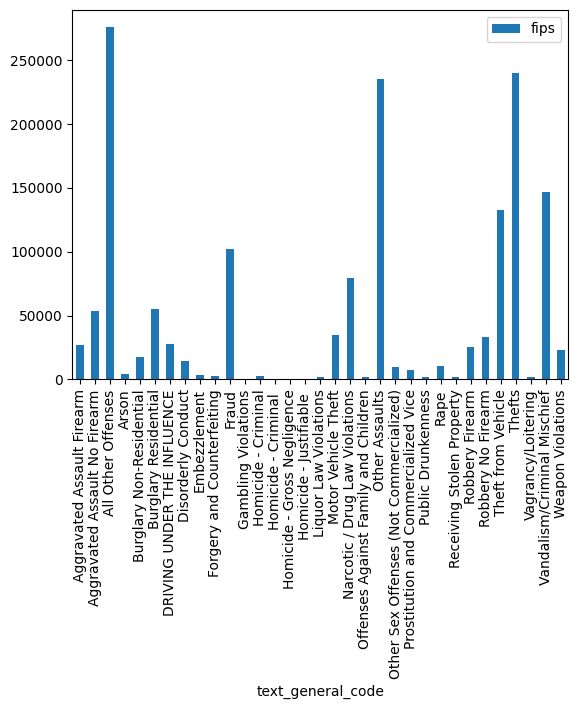

In [ ]:
dfs_2['crimes.csv'][['text_general_code','fips']].groupby(['text_general_code']).count().plot(kind='bar')

<Axes: xlabel='dispatch_date'>

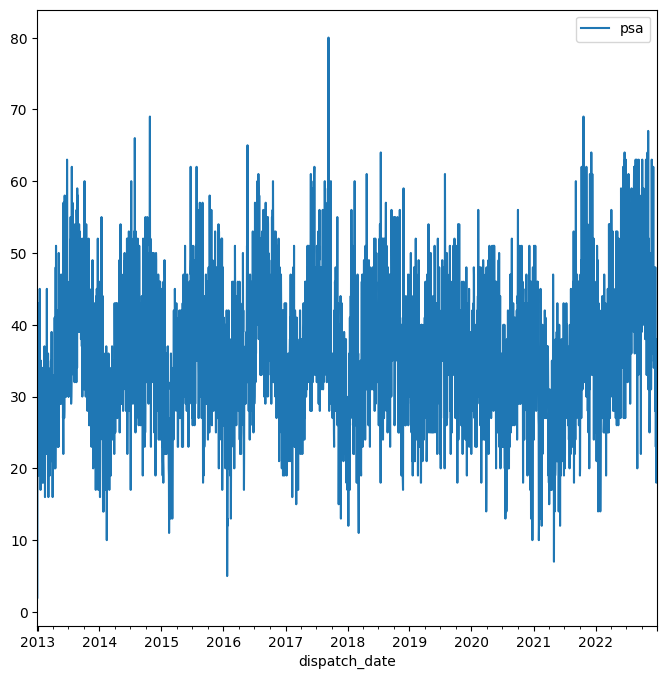

In [ ]:
## just vehicle crime
dfs_2['crimes.csv'][dfs_2['crimes.csv']['text_general_code'] == 'Theft from Vehicle']\
                    [['dispatch_date','psa']].groupby(['dispatch_date'])\
                    .count().plot(figsize=(8,8))

In [ ]:
### analysis about crime table
temp_df =  dfs_2['crimes.csv']

In [ ]:
temp_df['text_general_code'].nunique()

24

In [ ]:
temp_df[['text_general_code','Crime Cases']].groupby('text_general_code').sum().sort_values('Crime Cases')

,Crime Cases
text_general_code,
Homicide - Gross Negligence,1
Homicide - Justifiable,9
Gambling Violations,351
Homicide - Criminal,437
Liquor Law Violations,1661
Vagrancy/Loitering,1772
Receiving Stolen Property,1988
Offenses Against Family and Children,2177
Public Drunkenness,2242


In [ ]:
dfs_2['crimes.csv'].columns

Index(['objectid', 'psa', 'dispatch_date_time', 'dispatch_date',
       'dispatch_time', 'location_block', 'text_general_code', 'lat', 'lng',
       'fips'],
      dtype='object')

In [ ]:
temp_df =  dfs_2['crimes.csv'][['dispatch_time','objectid','dispatch_date_time']]
temp_df['hour'] = temp_df.dispatch_time.apply(lambda x: x[:2])
temp_df['year'] = temp_df.dispatch_date_time.dt.year
temp_df.drop(columns=['dispatch_time','dispatch_date_time'],inplace=True)
temp_df = temp_df.groupby(['hour','year']).count().reset_index()
temp_df = temp_df.sort_values('hour')
temp_df.rename(columns={'objectid':'Crime Cases'},inplace=True)
temp_df = temp_df[temp_df['year'].isin([2014,2015,2016,2017,2018])]
import plotly.express as px
# px.line(df, x="year", y="lifeExp", color='country')
fig = px.line(temp_df, x='hour', y='Crime Cases',color='year' ,title='In-day total crimes distribution in Philadelphia')
fig.show()

<ipython-input-6-8d1de1d7c482>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['hour'] = temp_df.dispatch_time.apply(lambda x: x[:2])
<ipython-input-6-8d1de1d7c482>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['year'] = temp_df.dispatch_date_time.dt.year
<ipython-input-6-8d1de1d7c482>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [ ]:
dfs_2['crimes.csv']['text_general_code'].value_counts()

All Other Offenses                         275519
Thefts                                     239789
Other Assaults                             234895
Vandalism/Criminal Mischief                146760
Theft from Vehicle                         132254
Fraud                                      102416
Narcotic / Drug Law Violations              79040
Burglary Residential                        54767
Aggravated Assault No Firearm               53239
Motor Vehicle Theft                         34914
Robbery No Firearm                          33364
DRIVING UNDER THE INFLUENCE                 28116
Aggravated Assault Firearm                  26798
Robbery Firearm                             25263
Weapon Violations                           22964
Burglary Non-Residential                    17529
Disorderly Conduct                          14346
Rape                                        10373
Other Sex Offenses (Not Commercialized)      9590
Prostitution and Commercialized Vice         7468


In [ ]:
### dispatch_time

temp_df =  dfs_2['crimes.csv'][['dispatch_time','objectid','text_general_code']]
temp_df['hour'] = temp_df.dispatch_time.apply(lambda x: x[:2])
temp_df.drop(columns=['dispatch_time'],inplace=True)
temp_df = temp_df.groupby(['hour','text_general_code']).count().reset_index()
temp_df = temp_df.sort_values('hour')
temp_df.rename(columns={'objectid':'Crime Cases'},inplace=True)
temp_df = temp_df[temp_df['text_general_code'].isin(['Forgery and Counterfeiting','Receiving Stolen Property','Narcotic / Drug Law Violations'])]
import plotly.express as px
fig = px.bar(temp_df, x='hour', y='Crime Cases', color='text_general_code' ,title='Crime distribution in day in total from 2014-2022')
fig.show()

<ipython-input-50-f274126e5d74>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-f274126e5d74>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
### dispatch_time
## month 
temp_df =  dfs_2['crimes.csv'][['dispatch_date','objectid']]
temp_df['year'] = temp_df.dispatch_date.dt.year
temp_df['month'] = temp_df.dispatch_date.dt.month
temp_df = temp_df[temp_df['year'].isin([i for i in range(2013,2023)])]
temp_df.drop(columns=['dispatch_date'],inplace=True)
temp_df = temp_df[['month','objectid']].groupby(['month']).count().reset_index()
# temp_df = temp_df.sort_values('month')
temp_df.rename(columns={'objectid':'Crime Cases'},inplace=True)
# temp_df['year'] = temp_df['year'].astype(str)
import plotly.express as px
fig = px.bar(temp_df, x='month', y='Crime Cases' ,title='Crime distribution monthly in total from 2013-2022')
fig.show()

<ipython-input-72-2ffc865fa102>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-72-2ffc865fa102>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-72-2ffc865fa102>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
### dispatch_time
## month 
temp_df =  dfs_2['crimes.csv'][['dispatch_date','objectid']]
temp_df['year'] = temp_df.dispatch_date.dt.year
temp_df['month'] = temp_df.dispatch_date.dt.month
temp_df = temp_df[temp_df['year'].isin([i for i in range(2013,2023)])]
temp_df.drop(columns=['dispatch_date'],inplace=True)
temp_df = temp_df[['month','objectid','year']].groupby(['month','year']).count().reset_index()
# temp_df = temp_df.sort_values('month')
temp_df.rename(columns={'objectid':'Crime Cases'},inplace=True)
# temp_df['year'] = temp_df['year'].astype(str)
import plotly.express as px
fig = px.bar(temp_df, x='month', y='Crime Cases',color='year' ,title='Crime distribution monthly in total from 2013-2022')
fig.show()

<ipython-input-5-d97547dddd28>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['year'] = temp_df.dispatch_date.dt.year
<ipython-input-5-d97547dddd28>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['month'] = temp_df.dispatch_date.dt.month
<ipython-input-5-d97547dddd28>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [ ]:
### dispatch_time
## day of week 
temp_df =  dfs_2['crimes.csv'][['dispatch_date','objectid']]
temp_df['year'] = temp_df.dispatch_date.dt.year
temp_df['day of week'] = temp_df.dispatch_date.dt.dayofweek
temp_df = temp_df[temp_df['year'].isin([i for i in range(2013,2023)])]
temp_df.drop(columns=['dispatch_date'],inplace=True)

temp_df = temp_df[['day of week','year','objectid']].groupby(['day of week','year']).count().reset_index()
# temp_df = temp_df.sort_values('month')
temp_df.rename(columns={'objectid':'Crime Cases'},inplace=True)
temp_df['day of week'] = temp_df['day of week'].replace({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
# temp_df['year'] = temp_df['year'].astype(str)
import plotly.express as px
fig = px.line(temp_df, x='day of week', y='Crime Cases',color='year' ,title='Crime distribution cross diffretn day of week from 2013-2022')
fig.show()

<ipython-input-13-6f217cb84f65>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-6f217cb84f65>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-6f217cb84f65>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
temp_df = dfs_2['traffic_stops_philadelphia.csv']
temp_df.columns

Index(['objectid', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'service_area', 'subject_age', 'subject_race', 'subject_sex', 'type',
       'arrest_made', 'outcome', 'contraband_found', 'frisk_performed',
       'search_conducted', 'search_person', 'search_vehicle', 'raw_race',
       'raw_individual_contraband', 'raw_vehicle_contraband', 'fips'],
      dtype='object')

In [96]:
dfs_2['traffic_stops_philadelphia.csv'].sort_values('date')

,objectid,date,time,location,lat,lng,district,service_area,subject_age,subject_race,...,outcome,contraband_found,frisk_performed,search_conducted,search_person,search_vehicle,raw_race,raw_individual_contraband,raw_vehicle_contraband,fips
0,1,2014-01-01,01:14:00,NaN,NaN,NaN,19.0,191,31.0,black,...,arrest,True,False,True,True,False,Black - Non-Latino,True,False,NaN
28,29,2014-01-01,14:20:00,200 BLOCK W COULTER ST,40.029207,-75.174554,39.0,391,40.0,white,...,NaN,NaN,False,False,False,False,White - Non-Latino,False,False,4.210102e+11
29,30,2014-01-01,14:35:00,6000 BLOCK SUMMER ST,39.965874,-75.240068,19.0,192,23.0,black,...,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False,4.210101e+11
30,31,2014-01-01,14:42:00,S 52ND/ MARKET ST,NaN,NaN,18.0,182,33.0,black,...,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False,NaN
31,32,2014-01-01,15:49:00,HANSBERRY ST / KNOX ST,40.028460,-75.169820,39.0,391,46.0,black,...,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False,4.210102e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864481,1864482,2018-04-14,10:45:00,1800 BLOCK E OAKDALE ST,39.989330,-75.125690,26.0,263,54.0,hispanic,...,NaN,NaN,False,False,False,False,White - Latino,False,False,4.210102e+11
1864482,1864483,2018-04-14,10:45:00,N 09TH ST / W LUZERNE ST,40.012720,-75.141790,25.0,251,55.0,black,...,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False,4.210102e+11
1864483,1864484,2018-04-14,10:47:00,2000 BLOCK W ALLEGHENY AV,40.002830,-75.162420,39.0,392,21.0,black,...,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False,4.210102e+11
1864471,1864472,2018-04-14,10:25:00,2900 BLOCK N 27TH ST,39.999770,-75.174910,39.0,391,32.0,unknown,...,NaN,NaN,False,False,False,False,Unknown,False,False,4.210102e+11


In [ ]:
### dispatch_time
## traffic stops
# temp_df =  dfs_2['traffic_stops_philadelphia.csv'][['time','arrest_made']]
temp_df =  dfs_2['traffic_stops_philadelphia.csv'][['time','objectid','date']]
temp_df['hour'] = temp_df.time.apply(lambda x: x[:2])
temp_df['year'] = temp_df.date.astype('datetime64[ns]').dt.year
temp_df.drop(columns=['time','date'],inplace=True)
temp_df = temp_df.groupby(['hour','year']).count().reset_index()
temp_df = temp_df.sort_values('hour')
temp_df.rename(columns={'objectid':'traffic stops'},inplace=True)
import plotly.express as px
# px.line(df, x="year", y="lifeExp", color='country')
fig = px.line(temp_df, x='hour', y='traffic stops',color='year' ,title='In-day total traffic stops distribution in Philadelphia')
fig.show()

<ipython-input-58-69b99011b531>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-58-69b99011b531>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-58-69b99011b531>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
|## total crimes through years
import plotly.express as px

temp_df =  dfs_2['crimes.csv']
temp_df = temp_df[['dispatch_date','objectid']].groupby('dispatch_date').count().reset_index()
temp_df.rename(columns={'objectid':'total','dispatch_date':'date'},inplace=True)
temp_df['year'] = temp_df['date'].dt.year

# temp_df.set_index("dispatch_date", inplace=True)

fig = px.line(temp_df, x="date", y="total", color='year')
fig.update_layout(
    xaxis_title="Date", yaxis_title="Total crime cases"
)
fig.show()
# temp_df.groupby('dispatched_year')['objectid'].plot(legend=True, xlabel="date", ylabel="total")
# # dfs_2['crimes.csv'][dfs_2['crimes.csv']['text_general_code'] == 'Theft from Vehicle']\
# #                     [['dispatch_date','psa']].groupby(['dispatch_date'])\
# #                     .count().plot(figsize=(8,8))
temp_df.sort_values('total',ascending=False).groupby('year').head(n=2)


,date,total,year
2709,2020-06-01,849,2020
2857,2020-10-27,778,2020
513,2014-05-28,707,2014
536,2014-06-20,693,2014
172,2013-06-21,666,2013
198,2013-07-17,661,2013
925,2015-07-14,645,2015
837,2015-04-17,643,2015
2452,2019-09-18,583,2019
2466,2019-10-02,579,2019


In [ ]:
print("num unique CRN in crash_info_general.csv: {}".format(dfs['crash_info_general.csv']['CRN'].nunique()))
print("num unique CRN in crash_info_motorcycle.csv: {}".format(dfs['crash_info_motorcycle.csv']['CRN'].nunique()))
print("num unique CRN in crash_info_vehicles.csv: {}".format(dfs['crash_info_vehicles.csv']['CRN'].nunique()))

num unique CRN in crash_info_general.csv: 133013
num unique CRN in crash_info_motorcycle.csv: 8349
num unique CRN in crash_info_vehicles.csv: 133013


In [ ]:
len(set(dfs['crash_info_vehicles.csv']['CRN'].unique()).intersection(set(dfs['crash_info_motorcycle.csv']['CRN'].unique())))

8349

In [ ]:
sample_df = dfs['investigations.csv']
sample_df['searched_ind'] = sample_df['individual_frisked'] + sample_df['individual_searched'] + sample_df['individual_arrested'] + sample_df['individual_contraband']

In [ ]:
sample_df['individual_contraband'].value_counts()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(sample_df['searched_ind']>0,sample_df['individual_contraband'] ,normalize='true')

In [ ]:
(sample_df['searched_ind']>0).value_counts()
sample_df['searched_veh'] = sample_df['vehicle_frisked'] + sample_df['vehicle_searched'] 

In [ ]:
|## total accident cases each month in Phil, quite similar with thief cases in Phil??
import seaborn as sns
temp_df = dfs['crash_info_general.csv']\
          [dfs['crash_info_general.csv']['CRASH_YEAR']>=2013]\
          [['CRASH_YEAR','CRASH_MONTH','CRN']].groupby(['CRASH_YEAR','CRASH_MONTH'])\
          .count().reset_index().set_index(['CRASH_YEAR','CRASH_MONTH'])
temp_df.plot()

In [ ]:
dfs['crash_info_general.csv'].columns

# New Section

In [ ]:

def _or_select(df,columns):
  for col in columns:
    assert col in df.columns
  df['_selected'] = df[columns].values.sum(axis=-1)
  return df[df['_selected']>0]

# geographical distribution of crime

In [20]:
data = dfs['crimes.csv']
data['GEOIDS'] = data['fips'].apply(lambda x: x[:11])
data['GEOIDS'].nunique()

405

In [31]:
dfs.keys()

dict_keys(['crash_info_commericial_vehicles.csv', 'crash_info_vehicles.csv', 'crash_info_trailed_vehicles.csv', 'crash_info_roadway.csv', 'crash_info_people.csv', 'crash_info_motorcycle.csv', 'crash_info_general.csv', 'crash_info_flag_variables.csv', 'crimes.csv', 'traffic_stops_philadelphia.csv', 'police_stations.csv', 'philadelphia_population_metrics.csv', 'investigations.csv', 'hourly_weather_philadelphia.csv', 'police_districts.csv'])

In [33]:
dfs['traffic_stops_philadelphia.csv'].keys()

Index(['objectid', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'service_area', 'subject_age', 'subject_race', 'subject_sex', 'type',
       'arrest_made', 'outcome', 'contraband_found', 'frisk_performed',
       'search_conducted', 'search_person', 'search_vehicle', 'raw_race',
       'raw_individual_contraband', 'raw_vehicle_contraband', 'fips'],
      dtype='object')

In [34]:
dfs['traffic_stops_philadelphia.csv'].sort_values('date')

,objectid,date,time,location,lat,lng,district,service_area,subject_age,subject_race,...,outcome,contraband_found,frisk_performed,search_conducted,search_person,search_vehicle,raw_race,raw_individual_contraband,raw_vehicle_contraband,fips
0,1,2014-01-01,01:14:00,NaN,NaN,NaN,19.0,191,31.0,black,...,arrest,True,False,True,True,False,Black - Non-Latino,True,False,NaN
28,29,2014-01-01,14:20:00,200 BLOCK W COULTER ST,40.029207,-75.174554,39.0,391,40.0,white,...,NaN,NaN,False,False,False,False,White - Non-Latino,False,False,4.210102e+11
29,30,2014-01-01,14:35:00,6000 BLOCK SUMMER ST,39.965874,-75.240068,19.0,192,23.0,black,...,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False,4.210101e+11
30,31,2014-01-01,14:42:00,S 52ND/ MARKET ST,NaN,NaN,18.0,182,33.0,black,...,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False,NaN
31,32,2014-01-01,15:49:00,HANSBERRY ST / KNOX ST,40.028460,-75.169820,39.0,391,46.0,black,...,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False,4.210102e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864481,1864482,2018-04-14,10:45:00,1800 BLOCK E OAKDALE ST,39.989330,-75.125690,26.0,263,54.0,hispanic,...,NaN,NaN,False,False,False,False,White - Latino,False,False,4.210102e+11
1864482,1864483,2018-04-14,10:45:00,N 09TH ST / W LUZERNE ST,40.012720,-75.141790,25.0,251,55.0,black,...,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False,4.210102e+11
1864483,1864484,2018-04-14,10:47:00,2000 BLOCK W ALLEGHENY AV,40.002830,-75.162420,39.0,392,21.0,black,...,NaN,NaN,False,False,False,False,Black - Non-Latino,False,False,4.210102e+11
1864471,1864472,2018-04-14,10:25:00,2900 BLOCK N 27TH ST,39.999770,-75.174910,39.0,391,32.0,unknown,...,NaN,NaN,False,False,False,False,Unknown,False,False,4.210102e+11


In [70]:
polygon

,GEOIDS,geometry,selected
9,42091202201,POLYGON ((40.06898880004883 -75.09674072265625...,True
10,42091202202,POLYGON ((40.05316925048828 -75.12212371826172...,True
11,42091202401,POLYGON ((40.07173538208008 -75.15406036376953...,True
12,42091202402,POLYGON ((40.06548309326172 -75.14309692382812...,True
13,42091202500,POLYGON ((40.084659576416016 -75.1764373779296...,True
...,...,...,...
400,42101980600,"POLYGON ((39.908935546875 -75.1806640625, 39.9...",True
401,42101980700,POLYGON ((39.89887237548828 -75.17347717285156...,True
402,42101980800,"POLYGON ((39.97286605834961 -75.2691879272461,...",True
403,42101980900,POLYGON ((39.882659912109375 -75.2524108886718...,True


In [93]:
import shapely
from shapely.geometry import Point, Polygon,MultiPoint
import geopandas as gpd
import numpy as np
data = dfs['crimes.csv']
data['GEOIDS'] = data['fips'].apply(lambda x: x[:11])
polygon = data.groupby('GEOIDS')[['lat','lng']].apply(lambda x: MultiPoint(x[['lng','lat']].values).convex_hull).reset_index()
polygon.rename(columns={0:'geometry'},inplace=True)
polygon['selected'] = polygon['geometry'].apply(lambda x: isinstance(x,shapely.geometry.polygon.Polygon))
polygon = polygon[polygon.selected]
my_geo_df = gpd.GeoDataFrame(polygon, geometry='geometry')
# my_geo_df = my_geo_df.to_crs("WGS84")
my_geo_df = my_geo_df.set_index('GEOIDS')

# data = data[data['GEOIDS']=='42101009600']
# points = data[['lat','lng']].values

# poly = MultiPoint(points).convex_hull

/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [94]:
my_geo_df = gpd.GeoDataFrame(polygon, geometry='geometry')
my_geo_df = my_geo_df.set_index('GEOIDS')

In [95]:
fig = px.choropleth_mapbox(
    my_geo_df,
    geojson=my_geo_df.geometry,
    locations=my_geo_df.index,
    # color="total stops",
    center=dict(lat=dfs['police_districts.csv']['LAT'].mean(), lon=dfs['police_districts.csv']['LNG'].mean()),
    mapbox_style="carto-positron",
    zoom=10,
    # hover_data=hover_cols,
    title='Census tract'
    # animation_frame="year-month"
)
fig.show()

1
2
3
4
5
6
7


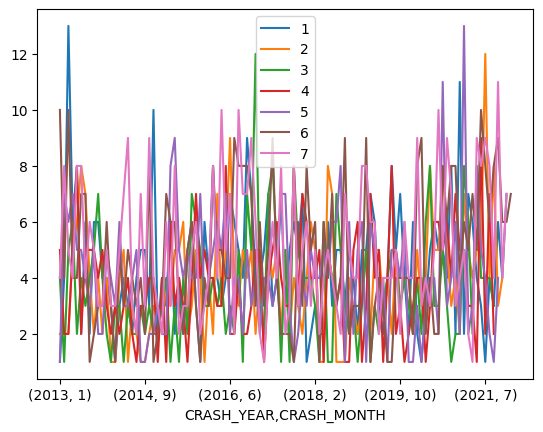

In [ ]:
new_df = _or_select(dfs['crash_info_general.csv'],columns=['DRIVER_COUNT_16YR', 'DRIVER_COUNT_17YR',
       'DRIVER_COUNT_18YR'])

new_df = new_df[new_df['CRASH_YEAR']>=2013]\
          [['CRASH_YEAR','CRASH_MONTH','CRN','DAY_OF_WEEK']].groupby(['CRASH_YEAR','CRASH_MONTH','DAY_OF_WEEK'])\
          .count().reset_index().set_index(['CRASH_YEAR','CRASH_MONTH'])
fig,ax = plt.subplots()
for name,group in new_df.groupby(['DAY_OF_WEEK']):
    print(name)
    group['CRN'].plot(ax=ax,label=name)
plt.legend()

In [ ]:
dfs['crash_info_general.csv'].columns

In [ ]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

sample_df = dfs_2[0]
sample_df = sample_df.groupby(['lng','lat'])['psa'].count().reset_index()
sample_df.rename(columns={'psa':'count'},inplace=True)
geometry = [Point(xy) for xy in zip(sample_df['lng'], sample_df['lat'])]
gdf = GeoDataFrame(sample_df[['lng','lat','count']], geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [ ]:
import folium
data = dfs['crimes.csv']
data.dropna(axis=0,inplace=True)
m = folium.Map(location=[data['lat'].mean(), data['lng'].mean()], zoom_start=10)

In [ ]:
for index, row in data.iterrows():
    folium.Marker(location=[row['lat'], row['lng']]).add_to(m)
m


# Predictive model for crimes

In [190]:
def _classify_discrete_features(df,threshold=0.3):
  """
  helper function to classify the features are discrete or not
  Args: 
    df: datagrame
    threshold: constant
  Returns:
    list of features that classified as discrete
  """
  feats = df.columns 
  n_samples = len(df)
  discrete_feats = []
  for feat in feats:
    if df[feat].nunique()/n_samples< threshold:
      discrete_feats.append(feat)
  return discrete_feats



def _extract_location_pos(df,location_col='location_block',lat_col='lat',lng_col='lng'):
  """
  Fucntion to extract the (lat,lng) of location in table
  """

  assert all([i in df.columns for i in (location_col,lat_col,lng_col)])
  sub_df = df[[location_col,lat_col,lng_col]].groupby(location_col).last().reset_index()
  sub_df.dropna(axis=0,inplace=True)
  return sub_df.set_index(location_col).to_dict(orient='index')

def _extract_GEOIDS_for_district(df,fips_col='fips',district_col='district'):
  assert fips_col in df.columns
  assert district_col in df.columns

  result = df[[fips_col,district_col]].drop_duplicates()
  result.dropna(axis=0,inplace=True)
  result['GEOIDS'] = result[fips_col].apply(lambda x: int(str(x)[:11]))
  result.drop(columns=[fips_col],inplace=True)
  result[district_col] = result[district_col].astype(int)
  result = result.groupby('GEOIDS').first().reset_index()
  return result

# _classify_discrete_features(dfs['crimes.csv'],threshold=0.3)
  


In [216]:
## extract geoids from traffic
list_geoids = _extract_GEOIDS_for_district(dfs['traffic_stops_philadelphia.csv'])
## 
columns = ['GEOGRAPHY_NAME','COUNT_ALL_RACES_ETHNICITIES',\
                                                  'COUNT_WHITE_NH',	'COUNT_BLACK_NH',	
                                                  'COUNT_ASIAN_NH',\
                                                'COUNT_HISPANIC']
pop = dfs['philadelphia_population_metrics.csv'][columns]
new_pop = pd.merge(pop,list_geoids,how='left',left_on='GEOGRAPHY_NAME',right_on='GEOIDS',suffixes=('_left','_right'))
columns.remove('GEOGRAPHY_NAME')
new_pop = new_pop[columns + ['district']].groupby('district').sum().reset_index()
# new_pop[columns] = new_pop[columns].values/new_pop[['COUNT_ALL_RACES_ETHNICITIES']].values


In [222]:
## plot .shp file in plotly
import requests
from pathlib import Path
from zipfile import ZipFile
import geopandas as gpd
import numpy as np
import plotly.express as px

geodf = gpd.read_file(geodf_path)

# shape file is a different CRS,  change to lon/lat GPS co-ordinates
geodf = geodf.to_crs("WGS84")
geodf = geodf.set_index('DIST_NUM')
tem_df = dfs['traffic_stops_philadelphia.csv'][['district','raw_race','objectid']]
# # tem_df['date'] = tem_df['date'].astype('datetime64[ns]')
# ## extract year and month
# tem_df['year-month'] = tem_df['date'].dt.year.astype(str) + '/' +   tem_df['date'].dt.month.astype(str) 
# tem_df.drop(columns=['date'],inplace=True)
tem_df = tem_df.groupby(['district','raw_race']).count().reset_index()
tem_df.rename(columns={'objectid':'total stops'},inplace=True)
tem_df = tem_df.groupby('district')[['total stops','raw_race']]\
                .apply(lambda x: [x['total stops']\
                  .sum(),{k:v for k,v in zip(x['raw_race'],x['total stops']/x['total stops'].sum())}])\
                  .reset_index()
tem_df[['total stops','detail']] = tem_df[0].apply(pd.Series)
tem_df.drop(columns=[0],inplace=True)
# tem_df = tem_df.sample(10000).sort_values(by='year-month')
tem_df = tem_df.join(pd.json_normalize(tem_df['detail'])).drop('detail', axis='columns')
hover_cols = [i for i in tem_df.columns if i not in ['total stops','district']]
# tem_df[hover_cols] = tem_df[hover_cols]/tem_df['total stops']
tem_df[hover_cols] = (tem_df[hover_cols]* 100).round(decimals=2)
fig = px.choropleth_mapbox(
    tem_df.set_index("district"),
    geojson=geodf.geometry,
    locations=tem_df.district,
    color="total stops",
    center=dict(lat=dfs['police_districts.csv']['LAT'].mean(), lon=dfs['police_districts.csv']['LNG'].mean()),
    mapbox_style="carto-positron",
    zoom=10,
    hover_data=hover_cols,
    title='Traffic stops by police in Philadelphia from 2014 to 2018'
    # animation_frame="year-month"
)

         

fig.show()

In [229]:
all_races = ['COUNT_WHITE_NH',	'COUNT_BLACK_NH',	
                                                  'COUNT_ASIAN_NH',\
                                         'COUNT_HISPANIC']
temp_df  =new_pop[all_races + ['district']]
new_df = temp_df.groupby('district')[all_races].apply(lambda x: all_races[x.sum().values.argmax()]).reset_index()
new_df.rename(columns={0:'race'},inplace=True)
new_df = new_df.set_index("district")
fig = px.choropleth_mapbox(
    new_df,
    geojson=geodf.geometry,
    locations=new_df.index,
    color="race",
    center=dict(lat=dfs['police_districts.csv']['LAT'].mean(), lon=dfs['police_districts.csv']['LNG'].mean()),
    mapbox_style="carto-positron",
    zoom=10,
    # hover_data='race',
    title='Prominent race of districts in  Philadelphia'
    # animation_frame="year-month"
)

         

fig.show()

,district,COUNT_ALL_RACES_ETHNICITIES,COUNT_WHITE_NH,COUNT_BLACK_NH,COUNT_ASIAN_NH,COUNT_HISPANIC
8,12,80760,9174,63310,3978,2278
16,24,83248,28717,13028,2353,37827
14,19,83545,6762,71336,1433,1962
5,7,91517,70196,5213,9221,4929
6,8,95476,70335,12943,3681,6769
9,14,99345,16888,76312,826,2672
2,3,100908,64369,10021,13580,10720
19,35,106869,6145,77882,8420,11940
1,2,114315,43461,32209,14356,20417
10,15,117115,62128,28529,3929,19410


In [ ]:
fig = px.scatter_mapbox(dfs['crimes.csv'].sample(10000), lat="lat", lon="lng", color="text_general_code",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10,
                  mapbox_style="carto-positron")
fig.show()

In [ ]:
tem_df.dtypes

dispatch_date    datetime64[ns]
lng                     float64
lat                     float64
psa                       int64
dtype: object

In [ ]:
tem_df

,dispatch_date,lng,lat,psa
165,2013-01-01,-75.184486,39.978519,1
121,2013-01-01,-75.225876,39.954819,8
471,2013-01-01,-75.041557,40.036396,1
787,2013-01-02,-75.128471,40.031319,1
661,2013-01-02,-75.167915,40.027905,1
...,...,...,...,...
1447819,2022-12-26,-74.970970,40.079182,1
1448138,2022-12-27,-75.089172,40.013309,1
1448646,2022-12-28,-74.961952,40.087593,1
1448766,2022-12-29,-75.179375,39.985134,1


In [ ]:
import plotly.express as px

tem_df = dfs['crimes.csv'][['dispatch_date','lng','lat','psa']]
## extract year and month
tem_df['year-month'] = tem_df['dispatch_date'].dt.year.astype(str) + '/' +   tem_df['dispatch_date'].dt.month.astype(str) 
tem_df.drop(columns=['dispatch_date'],inplace=True)
tem_df = tem_df.groupby(['year-month','lng','lat']).count().reset_index()
tem_df = tem_df.sample(10000).sort_values(by='year-month')
## animation
fig = px.density_mapbox(tem_df, lat='lat', 
                            lon='lng', 
                            z='psa',
                            radius=10,
                            animation_frame="year-month"
                                )

fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=10, mapbox_center = {"lat": tem_df['lat'].mean(), "lon": tem_df['lng'].mean()},)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 600
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 600
fig.layout.coloraxis.showscale = True   
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t= 10             

fig.show()



<ipython-input-73-5ed5dcbfe29f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-73-5ed5dcbfe29f>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
dfs['traffic_stops_philadelphia.csv'][['date','district','raw_race','objectid']]


Index(['objectid', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'service_area', 'subject_age', 'subject_race', 'subject_sex', 'type',
       'arrest_made', 'outcome', 'contraband_found', 'frisk_performed',
       'search_conducted', 'search_person', 'search_vehicle', 'raw_race',
       'raw_individual_contraband', 'raw_vehicle_contraband', 'fips'],
      dtype='object')

In [ ]:
tem_df = dfs['traffic_stops_philadelphia.csv'][['district','raw_race','objectid']]
# # tem_df['date'] = tem_df['date'].astype('datetime64[ns]')
# ## extract year and month
# tem_df['year-month'] = tem_df['date'].dt.year.astype(str) + '/' +   tem_df['date'].dt.month.astype(str) 
# tem_df.drop(columns=['date'],inplace=True)
tem_df = tem_df.groupby(['district','raw_race']).count().reset_index()
tem_df.rename(columns={'objectid':'total stops'},inplace=True)

In [ ]:
a = tem_df.groupby('district')[['total stops','raw_race']].apply(lambda x: [x['total stops'].sum(),{k:v for k,v in zip(x['raw_race'],x['total stops'])}]).reset_index()
## split columns
a[['total stops','detail']] = a[0].apply(pd.Series)
a.drop(columns=[0],inplace=True)

In [108]:
racial =dfs['philadelphia_population_metrics.csv'][['COUNT_ALL_RACES_ETHNICITIES'	,'COUNT_WHITE_NH',	
                                            'COUNT_BLACK_NH',	'COUNT_ASIAN_NH',	'COUNT_HISPANIC']].sum()
racial/racial.iloc[0] * 100

COUNT_ALL_RACES_ETHNICITIES    100.000000
COUNT_WHITE_NH                  36.866500
COUNT_BLACK_NH                  42.220476
COUNT_ASIAN_NH                   6.259543
COUNT_HISPANIC                  12.294250
dtype: float64

In [ ]:
## plot .shp file in plotly
import requests
from pathlib import Path
from zipfile import ZipFile
import geopandas as gpd
import numpy as np
import plotly.express as px

# # get the shape file...
# url = "https://avoidatastr.blob.core.windows.net/avoindata/AvoinData/9_Kartat/PKS%20postinumeroalueet/Shp/PKS_postinumeroalueet_2021_shp.zip"

# fn = Path.cwd().joinpath(url.split("/")[-1])
# if not fn.exists():
#     r = requests.get(url, stream=True)
#     with open(fn, "wb") as f:
#         for chunk in r.raw.stream(1024, decode_content=False):
#             if chunk:
#                 f.write(chunk)

# zfile = ZipFile(fn)
# zfile.extractall()

# # open it...
# geodf = gpd.read_file(list(Path.cwd().glob("PKS*.shp"))[0])
# geodf["rand"] = np.random.randint(1, 100, len(geodf))
geodf = gpd.read_file(geodf_path)


# shape file is a different CRS,  change to lon/lat GPS co-ordinates
geodf = geodf.to_crs("WGS84")
geodf = geodf.set_index('DIST_NUM')
tem_df = dfs['traffic_stops_philadelphia.csv'][['date','district','raw_race','objectid']]
tem_df['date'] = tem_df['date'].astype('datetime64[ns]')
## extract year and month
tem_df['year-month'] = tem_df['date'].dt.year.astype(str) + '/' +   tem_df['date'].dt.month.astype(str) 
tem_df.drop(columns=['date'],inplace=True)
tem_df = tem_df.groupby(['year-month','district','raw_race']).count().reset_index()
# tem_df = tem_df.sample(10000).sort_values(by='year-month')

fig = px.choropleth_mapbox(
    tem_df.set_index("district"),
    geojson=geodf.geometry,
    locations=tem_df.district,
    color="objectid",
    center=dict(lat=dfs['police_districts.csv']['LAT'].mean(), lon=dfs['police_districts.csv']['LNG'].mean()),
    mapbox_style="carto-positron",
    zoom=10,
    animation_frame="year-month"
)

fig.update_layout(
    height=1000,
    autosize=True,
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    paper_bgcolor="#303030",
    plot_bgcolor="#303030",
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 600
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 600
fig.layout.coloraxis.showscale = True   
fig.layout.sliders[0].pad.t = 10
fig.layout.updatemenus[0].pad.t= 10             

fig.show()

fig

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
tem_df = dfs['philadelphia_population_metrics.csv']
tem_df[['Shape__Area','Shape__Length']]


,Shape__Area,Shape__Length
0,1.202257e+06,4528.078584
1,6.516548e+05,3688.958965
2,9.319655e+05,5040.148986
3,3.978075e+05,2733.448537
4,5.174244e+05,3547.054900
...,...,...
376,1.303103e+07,14608.585727
380,1.278467e+07,19411.710980
381,3.700755e+06,16463.167578
382,3.498002e+07,40164.961498


In [152]:
dfs['traffic_stops_philadelphia.csv'].columns

Index(['objectid', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'service_area', 'subject_age', 'subject_race', 'subject_sex', 'type',
       'arrest_made', 'outcome', 'contraband_found', 'frisk_performed',
       'search_conducted', 'search_person', 'search_vehicle', 'raw_race',
       'raw_individual_contraband', 'raw_vehicle_contraband', 'fips', 'year'],
      dtype='object')

In [ ]:
dfs['philadelphia_population_metrics.csv'].GEOGRAPHY_NAME

0      42101000100
1      42101000200
2      42101000300
3      42101000401
4      42101000402
          ...     
376    42101980300
380    42101980700
381    42101980800
382    42101980900
383    42101989100
Name: GEOGRAPHY_NAME, Length: 381, dtype: int64

In [ ]:
dfs['investigations.csv'].columns

Index(['id', 'datetimeoccur', 'weekday', 'location', 'districtoccur', 'psa',
       'stoptype', 'inside_or_outside', 'gender', 'race', 'age',
       'individual_frisked', 'individual_searched', 'individual_arrested',
       'individual_contraband', 'vehicle_frisked', 'vehicle_searched',
       'vehicle_contraband', 'lat', 'lng', 'fips'],
      dtype='object')

In [ ]:
dfs['traffic_stops_philadelphia.csv'].columns

Index(['objectid', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'service_area', 'subject_age', 'subject_race', 'subject_sex', 'type',
       'arrest_made', 'outcome', 'contraband_found', 'frisk_performed',
       'search_conducted', 'search_person', 'search_vehicle', 'raw_race',
       'raw_individual_contraband', 'raw_vehicle_contraband', 'fips', 'hour'],
      dtype='object')

In [ ]:
## racial bias
tem_df = dfs['philadelphia_population_metrics.csv']
tem_df.columns

## plot .shp file in plotly
import requests
from pathlib import Path
from zipfile import ZipFile
import geopandas as gpd
import numpy as np
import plotly.express as px

geodf = gpd.read_file(geodf_path)

# shape file is a different CRS,  change to lon/lat GPS co-ordinates
geodf = geodf.to_crs("WGS84")
geodf = geodf.set_index('DIST_NUM')
tem_df = dfs['traffic_stops_philadelphia.csv'][['district','raw_race','objectid']]
# # tem_df['date'] = tem_df['date'].astype('datetime64[ns]')
# ## extract year and month
# tem_df['year-month'] = tem_df['date'].dt.year.astype(str) + '/' +   tem_df['date'].dt.month.astype(str) 
# tem_df.drop(columns=['date'],inplace=True)
tem_df = tem_df.groupby(['district','raw_race']).count().reset_index()
tem_df.rename(columns={'objectid':'total stops'},inplace=True)
tem_df = tem_df.groupby('district')[['total stops','raw_race']]\
                .apply(lambda x: [x['total stops']\
                  .sum(),{k:v for k,v in zip(x['raw_race'],x['total stops']/x['total stops'].sum())}])\
                  .reset_index()
tem_df[['total stops','detail']] = tem_df[0].apply(pd.Series)
tem_df.drop(columns=[0],inplace=True)
# tem_df = tem_df.sample(10000).sort_values(by='year-month')
tem_df = tem_df.join(pd.json_normalize(tem_df['detail'])).drop('detail', axis='columns')
hover_cols = [i for i in tem_df.columns if i not in ['total stops','district']]
# tem_df[hover_cols] = tem_df[hover_cols]/tem_df['total stops']
tem_df[hover_cols] = (tem_df[hover_cols]* 100).round(decimals=2)
fig = px.choropleth_mapbox(
    tem_df.set_index("district"),
    geojson=geodf.geometry,
    locations=tem_df.district,
    color="total stops",
    center=dict(lat=dfs['police_districts.csv']['LAT'].mean(), lon=dfs['police_districts.csv']['LNG'].mean()),
    mapbox_style="carto-positron",
    zoom=10,
    hover_data=hover_cols,
    title='Traffic stops by police in Philadelphia from 2013 to 2018'
    # animation_frame="year-month"
)

# fig.update_layout(
#     height=1000,
#     autosize=True,
#     margin={"r": 0, "t": 0, "l": 0, "b": 0},
#     paper_bgcolor='rgba(0,0,0,0)',
#     plot_bgcolor='rgba(0,0,0,0)',
# )

# fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 600
# fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 600
# fig.layout.coloraxis.showscale = True   
# fig.layout.sliders[0].pad.t = 10
# fig.layout.updatemenus[0].pad.t= 10             

fig.show()

Index(['OBJECTID', 'GEOGRAPHY_NAME', 'GEOGRAPHY',
       'COUNT_ALL_RACES_ETHNICITIES', 'COUNT_WHITE_NH', 'COUNT_BLACK_NH',
       'COUNT_ASIAN_NH', 'COUNT_HISPANIC', 'PERCENT_WHITE_NH',
       'PERCENT_BLACK_NH', 'PERCENT_ASIAN_NH', 'PERCENT_HISPANIC',
       'Shape__Area', 'Shape__Length'],
      dtype='object')

## how to formulaze the problem (crimes table) as predictive one?
 * Using tree-based model to predict the location of crimes?
 * What table we can use for crime prediction? 
    * crimes.csv, traffic_stop.csv, etc.
 # Create dataset

 * We can build two seperate model (with the same structure) from two dataset traffic_stop.csv and investigations.csv
 * More features can get from crimes.csv and hourly_weather_philadelphia.csv
 * Label for data: 
   * traffic_stops_philadelphia.csv: contraband_found
   * investigations.csv : vehicle_contraband
 * Should we drop the columns related police action(since the target is to predict the object before acting)

In [ ]:
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
len(geodf)

22

In [ ]:
dfs['traffic_stops_philadelphia.csv'][['raw_vehicle_contraband']].value_counts()

raw_vehicle_contraband
False                     1854043
True                        11053
dtype: int64

In [ ]:
dfs['traffic_stops_philadelphia.csv'][['raw_individual_contraband']].value_counts()

raw_individual_contraband
False                        1834072
True                           31024
dtype: int64

In [ ]:
dfs['traffic_stops_philadelphia.csv']['arrest_made'].value_counts()

False    1769620
True       95476
Name: arrest_made, dtype: int64

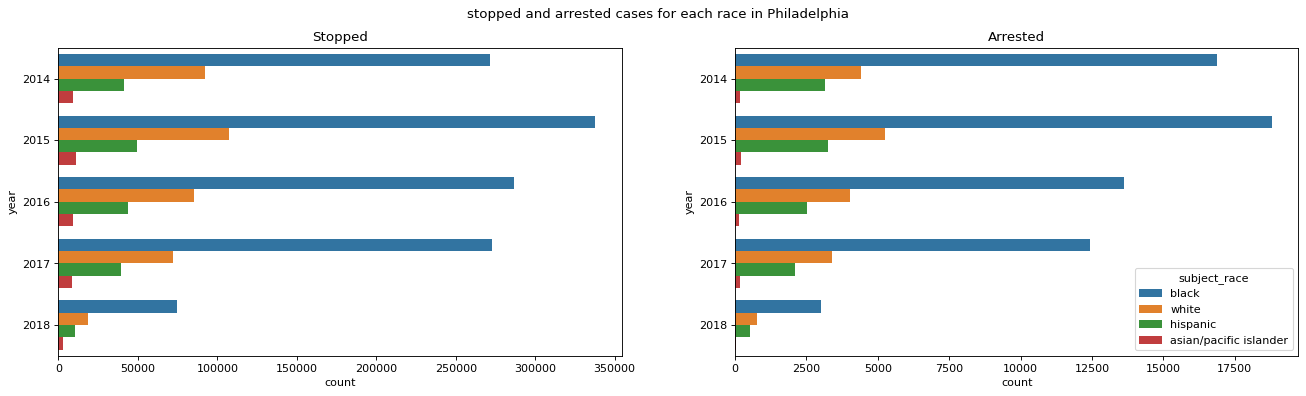

In [137]:
import seaborn as sns

temp_df = dfs['traffic_stops_philadelphia.csv']
temp_df['year'] = temp_df['date'].astype('datetime64[ns]').dt.year
## Arrested according racing
# temp_df[temp_df['arrest_made']]['raw_race'].hist(figsize=(30,6))
# fig = plt.gcf()
# fig.set_size_inches( 16, 10)
# sns.countplot(data=temp_df,hue='subject_race',y='year')
race = ['black', 'white','hispanic','asian/pacific islander']
temp_df = temp_df[temp_df['subject_race'].isin(race)]
# fig = plt.figure(figsize=(20, 5), dpi=80)
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), dpi=80)
# add subplots
sns.countplot(y='year', data=temp_df, hue='subject_race',ax=ax[0],hue_order=race)
ax[0].get_legend().remove()
ax[0].set_title('Stopped')

sns.countplot(y='year', data=temp_df[temp_df['arrest_made']], hue='subject_race',ax=ax[1],hue_order=race)
ax[1].set_title('Arrested')
# add legend
handles, labels = ax[-1].get_legend_handles_labels()
# fig.legend(handles, labels, ncol=3, bbox_to_anchor=(.75, 0.98))

# add subtitle
fig.suptitle('stopped and arrested cases for each race in Philadelphia')
fig.savefig('stop_arrest_race.png')
plt.show()

In [143]:
## number 
arrest = temp_df[temp_df['arrest_made']][['objectid','subject_race']]
arrest.groupby('subject_race').count()/temp_df[['objectid','subject_race']].groupby('subject_race').count() * 100

,objectid
subject_race,
asian/pacific islander,1.955522
black,5.202817
hispanic,6.279047
white,4.761854


In [145]:
[]

,OBJECTID,GEOGRAPHY_NAME,GEOGRAPHY,COUNT_ALL_RACES_ETHNICITIES,COUNT_WHITE_NH,COUNT_BLACK_NH,COUNT_ASIAN_NH,COUNT_HISPANIC,PERCENT_WHITE_NH,PERCENT_BLACK_NH,PERCENT_ASIAN_NH,PERCENT_HISPANIC,Shape__Area,Shape__Length
0,1,42101000100,Census tract,3478,2890,207,173,126,83.093732,5.951696,4.974123,3.622772,1.202257e+06,4528.078584
1,2,42101000200,Census tract,2937,665,284,1855,79,22.642152,9.669731,63.159687,2.689820,6.516548e+05,3688.958965
2,3,42101000300,Census tract,3169,2290,324,328,135,72.262543,10.224045,10.350268,4.260019,9.319655e+05,5040.148986
3,4,42101000401,Census tract,2125,1049,376,519,107,49.364706,17.694118,24.423529,5.035294,3.978075e+05,2733.448537
4,5,42101000402,Census tract,3142,2455,173,356,109,78.134946,5.506047,11.330363,3.469128,5.174244e+05,3547.054900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,377,42101980300,Census tract,2,2,0,0,0,100.000000,0.000000,0.000000,0.000000,1.303103e+07,14608.585727
380,381,42101980700,Census tract,5,0,3,1,1,0.000000,60.000000,20.000000,20.000000,1.278467e+07,19411.710980
381,382,42101980800,Census tract,6,4,1,0,0,66.666667,16.666667,0.000000,0.000000,3.700755e+06,16463.167578
382,383,42101980900,Census tract,30,9,18,0,2,30.000000,60.000000,0.000000,6.666667,3.498002e+07,40164.961498


<Axes: xlabel='count', ylabel='year'>

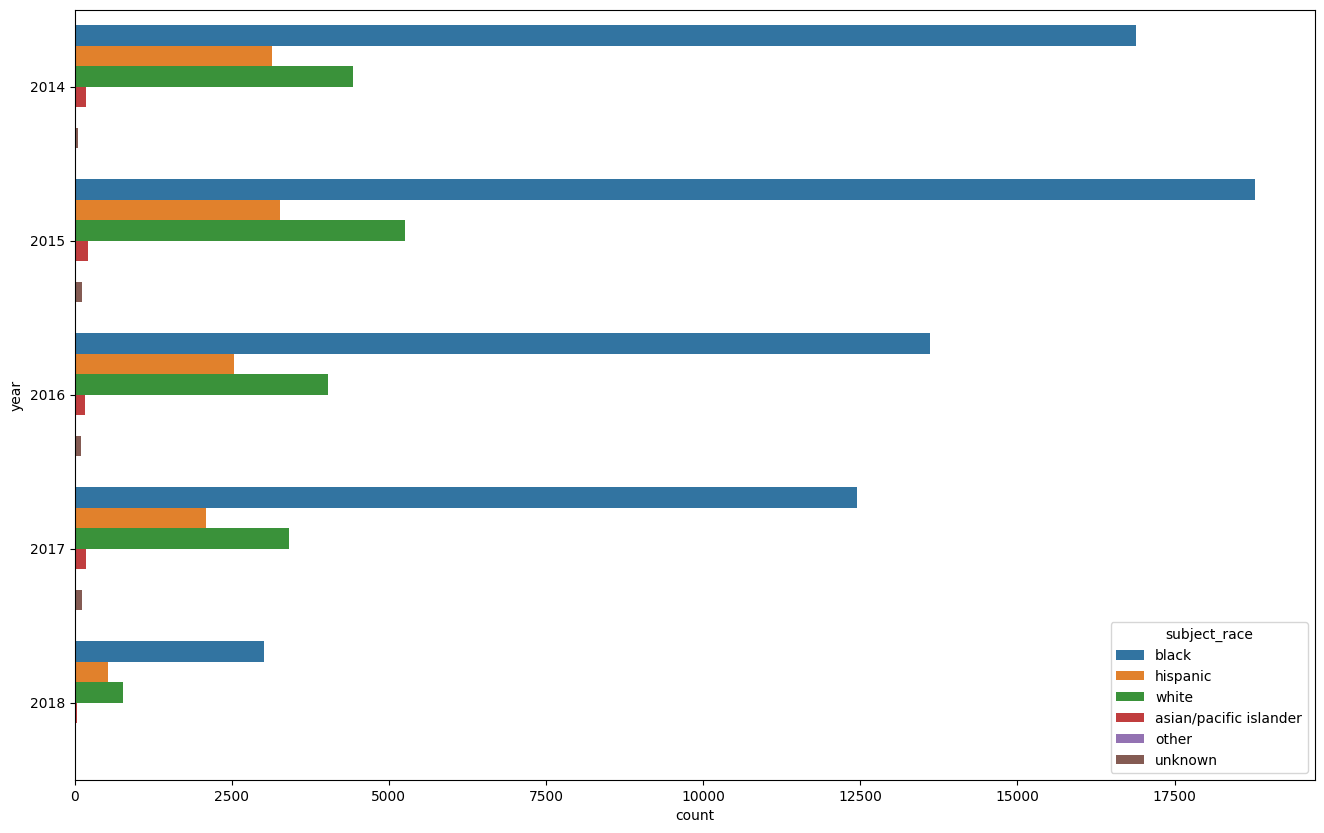

In [124]:
fig = plt.gcf()
fig.set_size_inches( 16, 10)
sns.countplot(data=temp_df[temp_df['arrest_made']],hue='subject_race',y='year')

In [151]:
pop = dfs['philadelphia_population_metrics.csv'][['COUNT_ALL_RACES_ETHNICITIES',	
                                            'COUNT_WHITE_NH',
                                            'COUNT_BLACK_NH',
                                            	'COUNT_ASIAN_NH',
                                            	'COUNT_HISPANIC']]
pop.sum()/pop.sum().iloc[0]

COUNT_ALL_RACES_ETHNICITIES    1.000000
COUNT_WHITE_NH                 0.368665
COUNT_BLACK_NH                 0.422205
COUNT_ASIAN_NH                 0.062595
COUNT_HISPANIC                 0.122943
dtype: float64

In [ ]:
|(temp_df['raw_vehicle_contraband'] | temp_df['raw_individual_contraband']).sum()/temp_df['arrest_made'].sum()

0.3851124890024718

In [ ]:
(temp_df['raw_vehicle_contraband'] | temp_df['raw_individual_contraband']).sum()/len(temp_df)

0.019714266718710457

<Axes: >

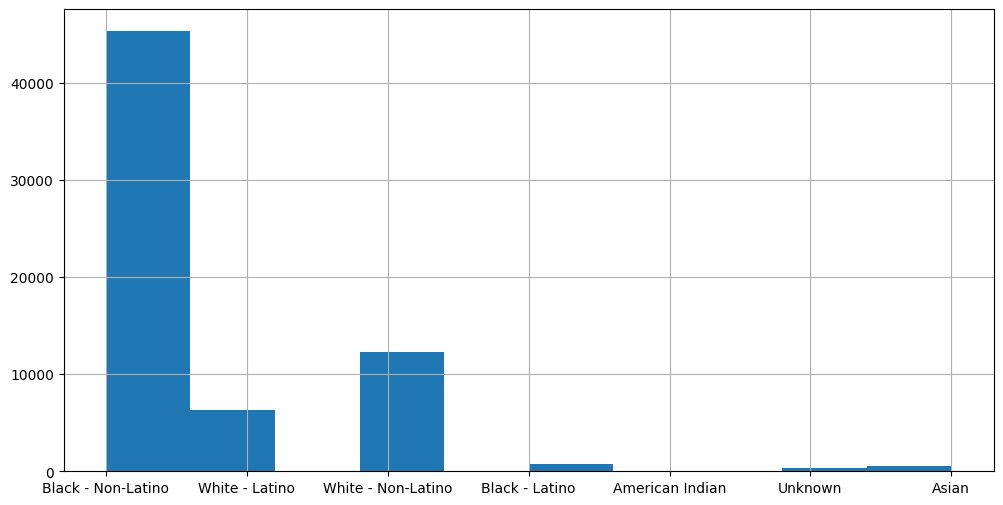

In [ ]:
## Arrested without contraband according racing
temp_df[(temp_df['arrest_made']) & (~temp_df['raw_vehicle_contraband'])& (~temp_df['raw_individual_contraband'])]['raw_race'].hist(figsize=(12,6))

<Axes: >

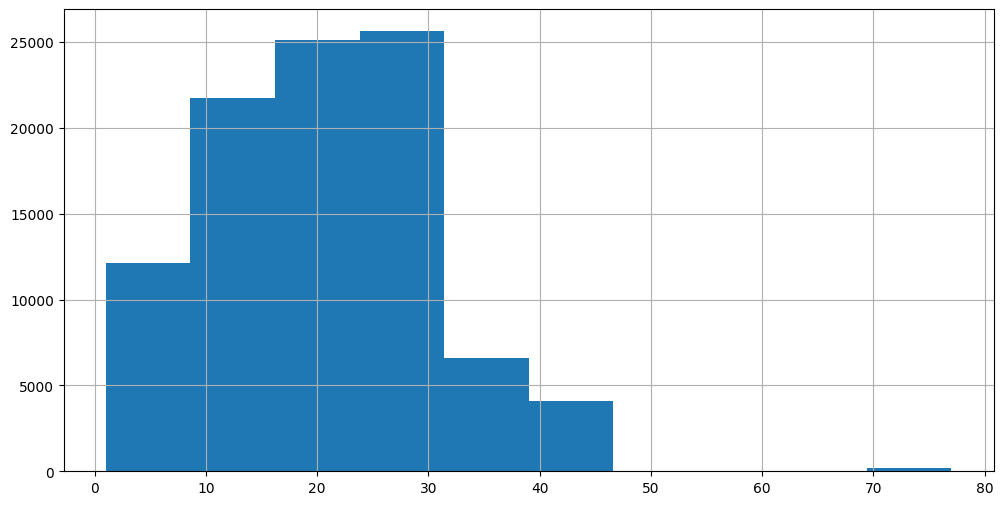

In [ ]:
## arrested rate distribute according police district
temp_df[temp_df['arrest_made']]['district'].hist(figsize=(12,6))

<Axes: >

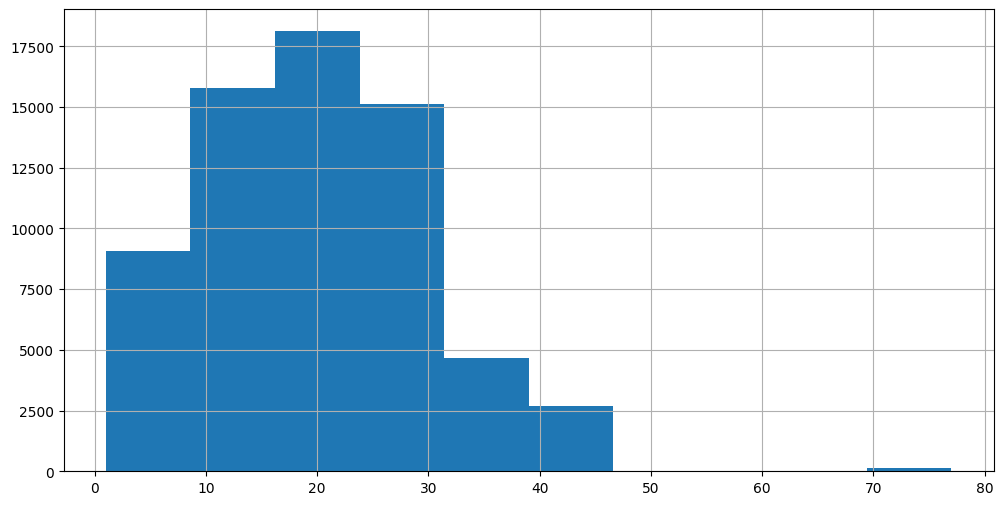

In [ ]:
## Arrested without evidence according district
temp_df[(temp_df['arrest_made']) & (~temp_df['raw_vehicle_contraband'])& (~temp_df['raw_individual_contraband'])]['district'].hist(figsize=(12,6))

<Axes: >

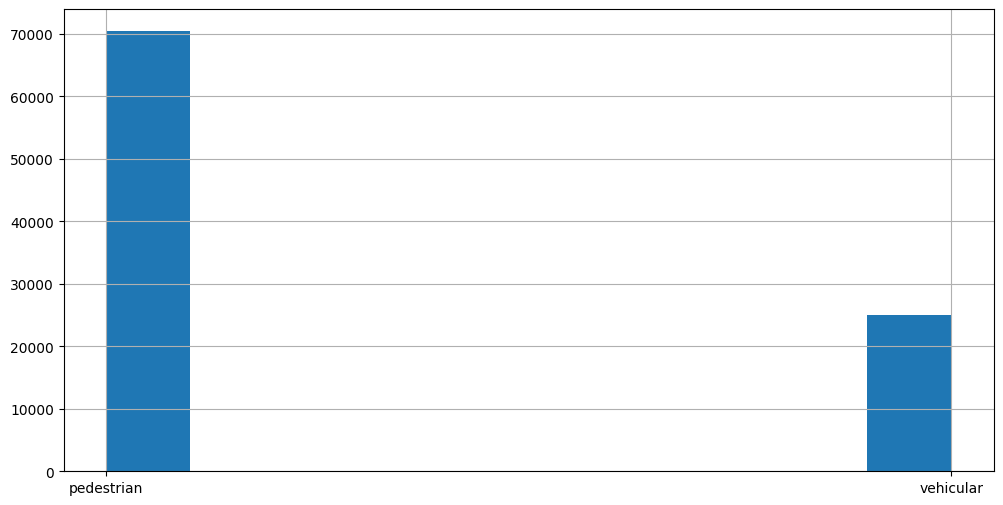

In [ ]:
## Arrested according type
temp_df[temp_df['arrest_made']]['type'].hist(figsize=(12,6))

In [ ]:
temp_df['district'].value_counts(normalize=True)

24.0    0.086776
19.0    0.079060
14.0    0.074927
35.0    0.073597
39.0    0.072059
25.0    0.068768
18.0    0.066041
22.0    0.064175
12.0    0.063184
15.0    0.047556
17.0    0.041069
3.0     0.040679
2.0     0.037307
26.0    0.033692
16.0    0.032101
1.0     0.024906
9.0     0.022498
6.0     0.022339
8.0     0.019509
7.0     0.015919
5.0     0.011330
77.0    0.002509
Name: district, dtype: float64

<Axes: >

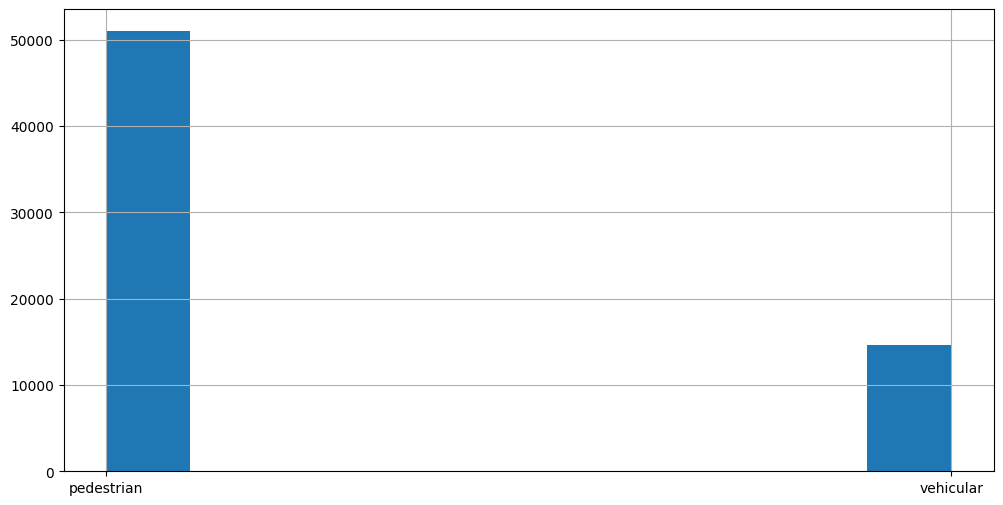

In [ ]:
## Arrested without evidence according type
temp_df[(temp_df['arrest_made']) & (~temp_df['raw_vehicle_contraband'])& (~temp_df['raw_individual_contraband'])]['type'].hist(figsize=(12,6))

In [ ]:
## are all contraband found arrested?
all((temp_df['raw_vehicle_contraband'] | temp_df['raw_individual_contraband']) == temp_df['arrest_made'])

False

In [ ]:
## just around 80% contraband cases found arrested!!!
((temp_df['raw_vehicle_contraband'] | temp_df['raw_individual_contraband']) & ~temp_df['arrest_made']).sum()/(temp_df['raw_vehicle_contraband'] | temp_df['raw_individual_contraband']).sum()

0.18697816095080094

In [ ]:
## 65% searched will be arrested
temp_df[temp_df['search_conducted']]['arrest_made'].value_counts(normalize=True)

True     0.644326
False    0.355674
Name: arrest_made, dtype: float64

In [ ]:
## 77% searched person will be arrested
temp_df[temp_df['search_person']]['arrest_made'].value_counts(normalize=True)

True     0.772492
False    0.227508
Name: arrest_made, dtype: float64

In [ ]:
## 71% search vehicle will be arrested
temp_df[temp_df['search_vehicle']]['arrest_made'].value_counts(normalize=True)

False    0.711776
True     0.288224
Name: arrest_made, dtype: float64

In [ ]:

## 79% frisk_performed will be arrested
temp_df[temp_df['frisk_performed']]['arrest_made'].value_counts(normalize=True)

False    0.793389
True     0.206611
Name: arrest_made, dtype: float64

In [ ]:
dfs['traffic_stops_philadelphia.csv'].fips.nunique()

1367

In [ ]:
temp_df = dfs['traffic_stops_philadelphia.csv']
temp_df['date'] = temp_df['date'].astype('datetime64[ns]')
## how to label??
guilty = (temp_df['raw_vehicle_contraband'] | temp_df['raw_individual_contraband'])
found = temp_df['contraband_found']
arrested = temp_df['arrest_made']
print(f"contraband founded:{(found & guilty).sum()/guilty.sum()}") ## 90% will be discovered ?? how they know ??
print(f"contraband arrested: {(arrested & guilty ).sum()/guilty.sum()}")
print(f"contraband founded & arrested: {(arrested & found ).sum()/found.sum()}")

contraband founded:0.9037504419483804
contraband arrested: 0.813021839049199
contraband founded & arrested: 0.8666265422810713




# Processing data



In [238]:
from pandas.core.groupby.groupby import T
## clean data
##first divide train test data
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
randomseed = 123

def _train_test_split(df,testsize=0.25,label='',random_state=123):
  """
  Function to divide train test
  Args:
    df: dataframe
    testsize: 
    label: label columns
  Returns:
    train,test dataframe
  """
  assert label in df.columns,f"label column {label} not in dataframe"
  test_index = df.groupby(label).sample(frac=testsize,random_state=random_state).index
  train_index = set(df.index).difference(set(test_index))
  assert np.allclose(df.loc[list(train_index)][label].value_counts(normalize=True),\
                     df.loc[list(test_index)][label].value_counts(normalize=True),atol=1e-4)
  return df.loc[list(train_index)], df.loc[list(test_index)]


## encoder for category features
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
def _select_encoder(s):
  if s=='onehot':
    return OneHotEncoder(handle_unknown='infrequent_if_exist',min_frequency=0.2)
  elif s=='ordinal':
    return OrdinalEncoder()
  else:
    raise ValueError(f'{s} is not implemented')  

def _onehot_encode(df,feats,encoder=None):

  if encoder == None:
    encoder = _select_encoder('onehot')
    
    new_feats = encoder.fit_transform(df[feats])
    df.drop(columns=feats,inplace=True)
    new_cols = []
    for feat in encoder.categories_:
      new_cols += [f"{feat}_{c}" for c in feat]
    # print(f"new cols: {encoder.categories_}")
    # print(f"new data: {new_feats.shape}")
    df[new_cols] = new_feats.todense()
    ## force handle unknown
    encoder.set_params(handle_unknown='use_encoded_value',unknown_value=-2)
  else:
    new_feats = encoder.transform(df[feats])
    df.drop(columns=feats,inplace=True)
    new_cols = []
    for feat in encoder.categories_:
      new_cols += [f"{feat}_{c}" for c in feat]
    # print(f"new cols: {encoder.categories_}")
    # print(f"new data: {new_feats.shape}")
    df[new_cols] = new_feats.todense()

  return df,encoder

def _ordinal_encode(df,feats,encoder=None):
  if encoder==None:
    encoder = _select_encoder('ordinal')
    df[feats] = encoder.fit_transform(df[feats].values)
    encoder.set_params(handle_unknown='use_encoded_value',unknown_value=df[feats].values.max()+1)
  else:
    df[feats] = encoder.transform(df[feats].values)
  return df,encoder


def _encode_cat_feats(df,catfeats=[],encode='ordinal',encoders=None):
  set_feats = set(catfeats)
  assert len(set_feats.intersection(set(df.columns)))==len(set_feats),\
       f"not all cat features {catfeats} in dataframe"
  if encoders is None:
    encoders = {} 
    encoder= None
  else:
    encode,encoder = list(encoders.items())[0]
  if encode=='onehot':
    df, encoders[encode] =  _onehot_encode(df,catfeats,encoder=encoder)
  elif encode =='ordinal':
    df,encoders[encode] = _ordinal_encode(df,catfeats,encoder=encoder)
  return df,encoders



def _fillna_func(df,fillna_values):

  for col in df.columns:
    t = str(df[col].dtype)
    
    if t in fillna_values:
      print(f"Nan values {col}: {df[col].isna().sum()/len(df)*100 :.2f} %")
      if t== 'object' and is_string_dtype(df[col]):
        df[col] = df[col].fillna('_').astype(str)
      elif t== 'object' and is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(-1.).astype('float64')

      else:
        ## check fillna_values[t] is function or not
        if hasattr(fillna_values[t],'__call__'):
          val = fillna_values[t](df[col])
          df[col] = df[col].fillna(val)
          ## change val in dict
          fillna_values[t] = val
        else: ## or just a value
          df[col] = df[col].fillna(fillna_values[t])
    else:
      raise ValueError(f"type {t} not in dicitonary")
  return df,fillna_values

## can use some aggrigate function (max,min,mode,etc)
fillna_values = {
                'int64':-1,
                 'float64': -1.,
                 'object': '_',
                 'bool':False,
                 'datetime64[ns]': pd.to_datetime('1993-03-25'),

                 }

# catfeats = [
#             'district', 
#             'service_area',
#             'subject_age',
#             'subject_race',
#             'subject_sex',
#             'type',
#             'fips'
#             ]

# continousfeats = [
#     'lat',
#     'lng'   
#         ]

# train,val = _train_test_split(dfs['traffic_stops_philadelphia.csv'],testsize=0.25,label='arrest_made',random_state=randomseed)
# train,fillna_values = _fillna_func(train,fillna_values)
# val,_ = _fillna_func(val,fillna_values)
# train_df,encoders = _encode_cat_feats(train,catfeats=catfeats,encode='ordinal')
# val_df,encoders = _encode_cat_feats(val,catfeats=catfeats,encode='ordinal',encoders=encoders)

In [ ]:
(dfs['traffic_stops_philadelphia.csv']['date'].astype(str) + ' ' +  dfs['traffic_stops_philadelphia.csv']['time'].astype(str)).astype('datetime64[ns]')

0         2014-01-01 01:14:00
1         2014-01-01 01:57:00
2         2014-01-01 03:30:00
3         2014-01-01 03:40:00
4         2014-01-01 08:30:00
                  ...        
1865091   2018-04-14 21:36:00
1865092   2018-04-14 22:01:00
1865093   2018-04-14 22:48:00
1865094   2018-04-14 22:48:00
1865095   2018-04-14 23:10:00
Length: 1865096, dtype: datetime64[ns]

# Calcuate new features

In [239]:
def _join_timedate_column(df,date,time):
  assert date in df.columns 
  assert time in df.columns 
  df[date] = df[date].astype(str) + ' ' + df[time].astype(str)
  df[date] = df[date].astype('datetime64[ns]')
  return df 



def _join_table_by_date(df1,col_date_1,df2,col_date_2,delta='1h',using_fips=False,*args):

  assert col_date_1 in df1.columns 
  assert col_date_2 in df2.columns 
  if using_fips:
    assert 'fips' in df1.columns
    assert 'fips' in df2.columns
    df1['fips'] = df1['fips'].astype('object')
    df2['fips'] = df2['fips'].astype('object')
  if str(df1[col_date_1].dtype) != 'datetime64[ns]':
    df1[col_date_1] = df1[col_date_1].astype('datetime64[ns]')
  df1 = df1.sort_values(col_date_1)
  df1[col_date_1] = df1[col_date_1].dt.round(delta)
  if str(df2[col_date_2].dtype) != 'datetime64[ns]': 
    df2[col_date_2] = df2[col_date_2].astype('datetime64[ns]')
  df2 = df2.sort_values(col_date_2)
  if using_fips:
    result = pd.merge(df1,df2,left_on=[col_date_1,'fips'],right_on=[col_date_2,'fips'],how='left',suffixes=('_left','_right'))
  else:
    result = pd.merge(df1,df2,left_on=col_date_1,right_on=col_date_2,how='left',suffixes=('_left','_right'))
  return result

import pandas as pd
from tqdm import tqdm
import os
import pdb
import numpy as np
def process_cum_stats(df,categorical_features,groupby=None):
    """
    df should have sort_column is time
    sort_column: feature to sort
    groupby: feature or list of features to group by
    categorical_features : list cat to calcualte cummulative stats
    """
    if groupby is None:
      new_cols = [feat + '_cumstats' for feat in categorical_features]
    else:
      new_cols = [feat + '_groupby_'+ groupby +  '_cumstats' for feat in categorical_features]
    # df = df.sort_values(sort_column,ascending=True)
    # for feat in tqdm(categorical_features)
    for i in tqdm(range(len(categorical_features))):
        ## this will calculate the percentage of each cat in  categorical_features[i] with the groupby 
        if groupby ==None:
          df[new_cols[i]] = df[categorical_features[i]].transform(lambda x: x.groupby(x).cumcount()/np.arange(1,len(x)+1))
        else:
          df[new_cols[i]] = df.groupby(groupby)[categorical_features[i]].transform(lambda x: x.groupby(x).cumcount()/np.arange(1,len(x)+1))

    return df,new_cols


def process_day_stats(df,categorical_features,groupby='',day_column='day',previous=True):
    """
    df should have sort_column is time
    groupby: feature or list of features to group by
    categorical_features : list cat to calcualte cummulative stats
    """
    if groupby is None:
      new_cols = [feat +  '_daystats' for feat in categorical_features]
      grouplist = []
    else:
      new_cols = [feat + '_groupby_'+ groupby +  '_daystats' for feat in categorical_features]
      grouplist = [groupby]
    # df = df.sort_values(sort_column,ascending=True)
    # for feat in tqdm(categorical_features)
    for i in tqdm(range(len(categorical_features))):
        ## this will calculate the percentage of each cat in  categorical_features[i] with the groupby 
        df['total_day_count'] = df.groupby(day_column)[categorical_features[i]].transform('count')
        if previous:
          df[new_cols[i]] = df.groupby(categorical_features[i])['total_day_count'].transform(lambda x: x.shift(1))
        else:
          df[new_cols[i]] = df.groupby(groupby + [day_column])[categorical_features[i]].transform(lambda x: x.groupby(x).cumcount())
          df[new_cols[i]] = df[new_cols[i]]/df['total_day_count']
    df.drop(columns='total_day_count',inplace=True)
    return df,new_cols




In [ ]:
dfs['traffic_stops_philadelphia.csv'].columns

Index(['objectid', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'service_area', 'subject_age', 'subject_race', 'subject_sex', 'type',
       'arrest_made', 'outcome', 'contraband_found', 'frisk_performed',
       'search_conducted', 'search_person', 'search_vehicle', 'raw_race',
       'raw_individual_contraband', 'raw_vehicle_contraband', 'fips', 'hour'],
      dtype='object')

In [ ]:
dfs['investigations.csv'].stoptype.value_counts()

vehicle       1994416
pedestrian     790671
Name: stoptype, dtype: int64

In [ ]:
dfs['investigations.csv'].columns

Index(['id', 'datetimeoccur', 'weekday', 'location', 'districtoccur', 'psa',
       'stoptype', 'inside_or_outside', 'gender', 'race', 'age',
       'individual_frisked', 'individual_searched', 'individual_arrested',
       'individual_contraband', 'vehicle_frisked', 'vehicle_searched',
       'vehicle_contraband', 'lat', 'lng', 'fips'],
      dtype='object')

In [ ]:
a.columns

Index(['objectid', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'service_area', 'subject_age', 'subject_race', 'subject_sex', 'type',
       'arrest_made', 'outcome', 'contraband_found', 'frisk_performed',
       'search_conducted', 'search_person', 'search_vehicle', 'raw_race',
       'raw_individual_contraband', 'raw_vehicle_contraband', 'fips', 'hour'],
      dtype='object')

In [ ]:
a = dfs['traffic_stops_philadelphia.csv']
a[(a['search_vehicle']) | (a['search_person'])]['date'].value_counts(normalize=True).sort_values()

2017-01-27 15:25:00    0.000009
2014-04-02 10:10:00    0.000009
2014-04-02 10:16:00    0.000009
2014-04-02 10:22:00    0.000009
2014-04-02 01:02:00    0.000009
                         ...   
2014-09-03 17:45:00    0.000077
2015-06-18 21:00:00    0.000077
2016-08-30 18:10:00    0.000077
2014-11-13 10:00:00    0.000077
2017-11-29 18:50:00    0.000077
Name: date, Length: 90767, dtype: float64

In [ ]:
90767/len(a)

0.048666127641687075

In [269]:
dfs['traffic_stops_philadelphia.csv']['subject_age']

0          31.0
1          21.0
2          24.0
3          20.0
4          31.0
           ... 
1865091    60.0
1865092    33.0
1865093    21.0
1865094    22.0
1865095    69.0
Name: subject_age, Length: 1865096, dtype: float64

In [270]:
catfeats = [
            'district', 
            'service_area',
            # 'subject_age',
            'subject_race',
            'subject_sex',
            'type',
            'fips',
            'hour',
            'searched',
            'dow',
            'month'

            ]

continousfeats = [
    'lat',
    'lng' ,
      'air_temp',
      'dew_point_temp',
      'relative_humidity',
      'avg_wind_direction',
      'subject_age',
      'avg_wind_speed',

      'avg_sea_level_air_pressure',
      
        ]

In [271]:
_catfeats = [
            'district', 
            'service_area',
            # 'subject_age',
            # 'subject_race',
            'subject_sex',
            'type',
            # 'fips',

            ]
## add features from crime dataset
crime_catfeats = ['fips']
added_df = dfs['crimes.csv']
added_df = added_df.sort_values('dispatch_date_time')
added_df['dispatch_date'] = added_df['dispatch_date'].astype('datetime64[ns]')
added_df,added_cols = process_day_stats(added_df,categorical_features=crime_catfeats,groupby='psa',day_column='dispatch_date',previous=True)

data = dfs['traffic_stops_philadelphia.csv']
data['searched'] = (data['search_vehicle']) | (data['search_person'])
data = _join_timedate_column(data,'date','time')
## add month,dow,hour feats
data['month']  = data['date'].dt.month
data['dow']  = data['date'].dt.dayofweek
data['hour'] = data['date'].dt.hour

## still need date time to this point
result = _join_table_by_date(data,'date',
                             dfs['hourly_weather_philadelphia.csv'],'datetime',delta='1h')
# new_results,new_cols = process_cum_stats(result,categorical_features=_catfeats,groupby='subject_race')
new_results,new_cols = process_day_stats(result,categorical_features=_catfeats,groupby='subject_race',day_column='date',previous=True)

new_results = _join_table_by_date(new_results,'date',added_df[['dispatch_date','fips'] + added_cols],'dispatch_date',delta='1D',using_fips=True)

100%|██████████| 4/4 [00:03<00:00,  1.04it/s]
<ipython-input-239-52b9c2d966d4>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [272]:
def _update_dict(dict1,dict2):
  """
  iupdate dict 2 to dict 1
  """
  for k in dict2:
    if k not in dict1:
      dict1[k] = dict2[k]
  return dict1

def _normalize_dict(dict1):
  
  s = 0 
  for k,v in dict1.items():
    s += v 
  for k in dict1:
    dict1[k]/=s 
  return dict1



def _calculate_weight(train_df,test_df,catfeats,id='objectid'):
  """
  How to calculate 
  """
  assert id in train_df.columns
  assert id in test_df.columns
  weights = np.ones(shape=(len(train_df),))
  for feat in catfeats:
    origin_dict = {i:1e-2 for i in train_df[feat].unique()}
    temp_weights_dict = test_df[feat].value_counts(normalize=True).to_dict()
    temp_weights_dict = _update_dict(temp_weights_dict,origin_dict)
    temp_weights = train_df[feat].replace(temp_weights_dict).values
    weights *= temp_weights
  
  return weights/weights.sum()
  


In [273]:
continousfeats

['lat',
 'lng',
 'air_temp',
 'dew_point_temp',
 'relative_humidity',
 'avg_wind_direction',
 'subject_age',
 'avg_wind_speed',
 'avg_sea_level_air_pressure']

# Train lightgbm

In [275]:
label = 'arrest_made'
continousfeats = list(set(continousfeats + new_cols + added_cols))
feats = list(set(catfeats + continousfeats))

## create cummulative features for dow
new_results,added_cols = process_cum_stats(new_results,categorical_features=catfeats,groupby='dow')
continousfeats = list(set(continousfeats +  added_cols))
### 
n_data = len(new_results)
n_train = int(0.8 * n_data)
train_data,test = new_results.iloc[:n_train],new_results.iloc[n_train:]
# train,val = _train_test_split(train_data,testsize=0.25,label=label,random_state=randomseed)
# train,fillna_values = _fillna_func(train,fillna_values)
train,fillna_values = _fillna_func(train_data,fillna_values)
# val,_ = _fillna_func(val,fillna_values)

## ## tricky weights
train_weights = (train['searched']) & (~train[label])
train_weights +=1
train_weights *= 2
train_df,encoders = _encode_cat_feats(train,catfeats=catfeats,encode='ordinal')
# val_df,_ = _encode_cat_feats(val,catfeats=catfeats,encode='ordinal',encoders=encoders)
test_df,_ = _encode_cat_feats(test,catfeats=catfeats,encode='ordinal',encoders=encoders)

# ## sub select data 
# train_df = train_df[(train_df['search_vehicle']) | (train_df['search_person'])]
# val_df = val_df[(val_df['search_vehicle']) | (val_df['search_person'])]
# train_weights = _calculate_weight(train_df,test_df,catfeats=catfeats,id='objectid')

# assert np.all(train_weights!=0)
import lightgbm as lgb
train_data = lgb.Dataset(train_df[feats], label=train_df[label], feature_name=feats, categorical_feature=catfeats,
                         weight=train_weights
                         )
# val_data = train_data.create_valid(val_df[feats], label=val_df[label])

from sklearn.metrics import f1_score,precision_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

def lgb_precision_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'precision', precision_score(y_true, y_hat), True
param = {
                'num_leaves': 32, ## should larger
                # 'max_bin':150, ## should larger
                # 'min_data_in_leaf': 16,
                'max_depth':5, ## should larger
                # 'feature_fraction':0.3,
                # 'bagging_fraction':0.6,
                # 'lambda_l1': 0.04,
                # 'lambda_l2': 0.02,
                # 'pos_bagging_fraction':0.5,
                # 'neg_bagging_fraction':0.05,

                'num_iterations':1000 , #
                # 'verbose':1,
                # 'bagging_freq':3,
                'deterministic':True,
                'early_stopping_round':20,
                'random_state':42,
                'learner':'voting',
                # 'feature_fraction_bynode': 0.7,
                # 'learning_rate':0.15,
                'metric':'auc'
                }
# bst = lgb.train(param, train_data, valid_sets=[val_data],feval=lgb_f1_score)
bst = lgb.cv(param, train_data,feval=lgb_f1_score,nfold=5,return_cvbooster=True)

100%|██████████| 10/10 [00:06<00:00,  1.54it/s]
<ipython-input-238-b3a914a72567>:112: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Nan values objectid: 0.00 %
Nan values date: 0.00 %
Nan values time: 0.00 %


<ipython-input-238-b3a914a72567>:100: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Nan values location: 2.31 %
Nan values lat: 6.53 %
Nan values lng: 6.53 %
Nan values district: 0.00 %
Nan values service_area: 0.00 %
Nan values subject_age: 0.26 %
Nan values subject_race: 0.00 %
Nan values subject_sex: 0.04 %
Nan values type: 0.00 %
Nan values arrest_made: 0.00 %
Nan values outcome: 94.70 %
Nan values contraband_found: 94.10 %
Nan values frisk_performed: 0.00 %
Nan values search_conducted: 0.00 %
Nan values search_person: 0.00 %
Nan values search_vehicle: 0.00 %
Nan values raw_race: 0.00 %
Nan values raw_individual_contraband: 0.00 %
Nan values raw_vehicle_contraband: 0.00 %
Nan values fips: 6.53 %
Nan values year: 0.00 %
Nan values searched: 0.00 %
Nan values month: 0.00 %
Nan values dow: 0.00 %
Nan values hour: 0.00 %
Nan values Unnamed: 0: 0.00 %
Nan values datetime: 0.00 %
Nan values air_temp: 0.00 %
Nan values dew_point_temp: 0.00 %
Nan values relative_humidity: 0.00 %
Nan values precipitation: 0.90 %
Nan values snow_depth: 100.00 %
Nan values avg_wind_direction

<ipython-input-238-b3a914a72567>:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-238-b3a914a72567>:71: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:573: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] Unknown parameter: learner
[LightGBM] [Warning] Unknown parameter: learner
[LightGBM] [Warning] Unknown parameter: learner
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6106
[LightGBM] [Info] Number of data points in the train set: 1193660, number of used features: 33
[LightGBM] [Warning] Unknown parameter: learner
[LightGBM] [Warning] Unknown parameter: learner
[LightGBM] [Warning] Unknown parameter: learner
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.167023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6106
[LightGBM] [Info] Number of data points in the train set: 1193661, number of used features:

In [284]:
continousfeats

['hour_groupby_dow_cumstats',
 'subject_age',
 'fips_groupby_psa_daystats',
 'subject_race_groupby_dow_cumstats',
 'lng',
 'dew_point_temp',
 'type_groupby_dow_cumstats',
 'service_area_groupby_subject_race_daystats',
 'month_groupby_dow_cumstats',
 'avg_wind_direction',
 'fips_groupby_dow_cumstats',
 'district_groupby_dow_cumstats',
 'type_groupby_subject_race_daystats',
 'avg_sea_level_air_pressure',
 'avg_wind_speed',
 'district_groupby_subject_race_daystats',
 'service_area_groupby_dow_cumstats',
 'subject_sex_groupby_subject_race_daystats',
 'searched_groupby_dow_cumstats',
 'relative_humidity',
 'subject_sex_groupby_dow_cumstats',
 'air_temp',
 'dow_groupby_dow_cumstats',
 'lat']

In [280]:
 'fips_groupby_psa_daystats',
 'service_area_groupby_subject_race_daystats',
 'type_groupby_subject_race_daystats',
 'district_groupby_subject_race_daystats',
 'subject_sex_groupby_subject_race_daystats',


['hour_groupby_dow_cumstats',
 'subject_age',
 'fips_groupby_psa_daystats',
 'subject_race_groupby_dow_cumstats',
 'lng',
 'dew_point_temp',
 'type_groupby_dow_cumstats',
 'service_area_groupby_subject_race_daystats',
 'month_groupby_dow_cumstats',
 'avg_wind_direction',
 'fips_groupby_dow_cumstats',
 'district_groupby_dow_cumstats',
 'type_groupby_subject_race_daystats',
 'avg_sea_level_air_pressure',
 'avg_wind_speed',
 'district_groupby_subject_race_daystats',
 'service_area_groupby_dow_cumstats',
 'subject_sex_groupby_subject_race_daystats',
 'searched_groupby_dow_cumstats',
 'relative_humidity',
 'subject_sex_groupby_dow_cumstats',
 'air_temp',
 'dow_groupby_dow_cumstats',
 'lat']

In [279]:
bst

{'auc-mean': [0.9460087454737366,
  0.9479601347228115,
  0.9487659597961826,
  0.9490804616904605,
  0.9493053893600049,
  0.9495061382159318,
  0.9498039192197943,
  0.9501337801879721,
  0.9503106154549498,
  0.9504814993480419,
  0.9506770515771281,
  0.9509082779221089,
  0.9510980838876646,
  0.9511444839277006,
  0.9511631911517433,
  0.9512207776663167,
  0.9512803798455384,
  0.951324231453938,
  0.9514183215726153,
  0.951452598474536,
  0.9515312752621942,
  0.9515742378255423,
  0.9516413773783065,
  0.9517023578731983,
  0.9517684425056302,
  0.9518029783469876,
  0.951869790352883,
  0.9519158982549255,
  0.9519400010342192,
  0.9519955448137395,
  0.952025354014776,
  0.9520364233237244,
  0.9520342273079647,
  0.9520718171233703,
  0.952102780691064,
  0.9520988476682033,
  0.9520865636600255,
  0.9521131014459494,
  0.9521330748230683,
  0.9521261050985406,
  0.9521467141195847,
  0.9521676040210034,
  0.9521910953255777,
  0.9521891341411728,
  0.9521964461979436,
  0

In [ ]:
from sklearn.metrics import confusion_matrix
# test_data = train_data.create_valid(test_df[feats], label=test_df[label])
new_test_df = test_df[(test_df['search_vehicle']) | (test_df['search_person'])]
confusion_matrix(new_test_df[label], bst.predict(new_test_df[feats])>0.5)

array([[ 6688,  7604],
       [ 2067, 12103]])

In [253]:
from sklearn.metrics import f1_score,recall_score,precision_score,accuracy_score

def predict_all(y_true,y_pred):
  print(f"f1 score: {f1_score(y_true,y_pred)*100:.2f}, recall score: {recall_score(y_true,y_pred)*100:.2f}, precision score: {precision_score(y_true,y_pred)*100:.2f}")

# predict_all(test_df[label], bst.predict(test_df[feats])>0.5)

In [282]:
for i in range(5):
  predict_all(test_df[label], bst['cvbooster'].boosters[i].predict(test_df[feats])>0.5)

f1 score: 65.21, recall score: 58.31, precision score: 73.95
f1 score: 65.06, recall score: 57.83, precision score: 74.35
f1 score: 65.26, recall score: 58.25, precision score: 74.18
f1 score: 65.11, recall score: 57.94, precision score: 74.32
f1 score: 65.15, recall score: 58.04, precision score: 74.25


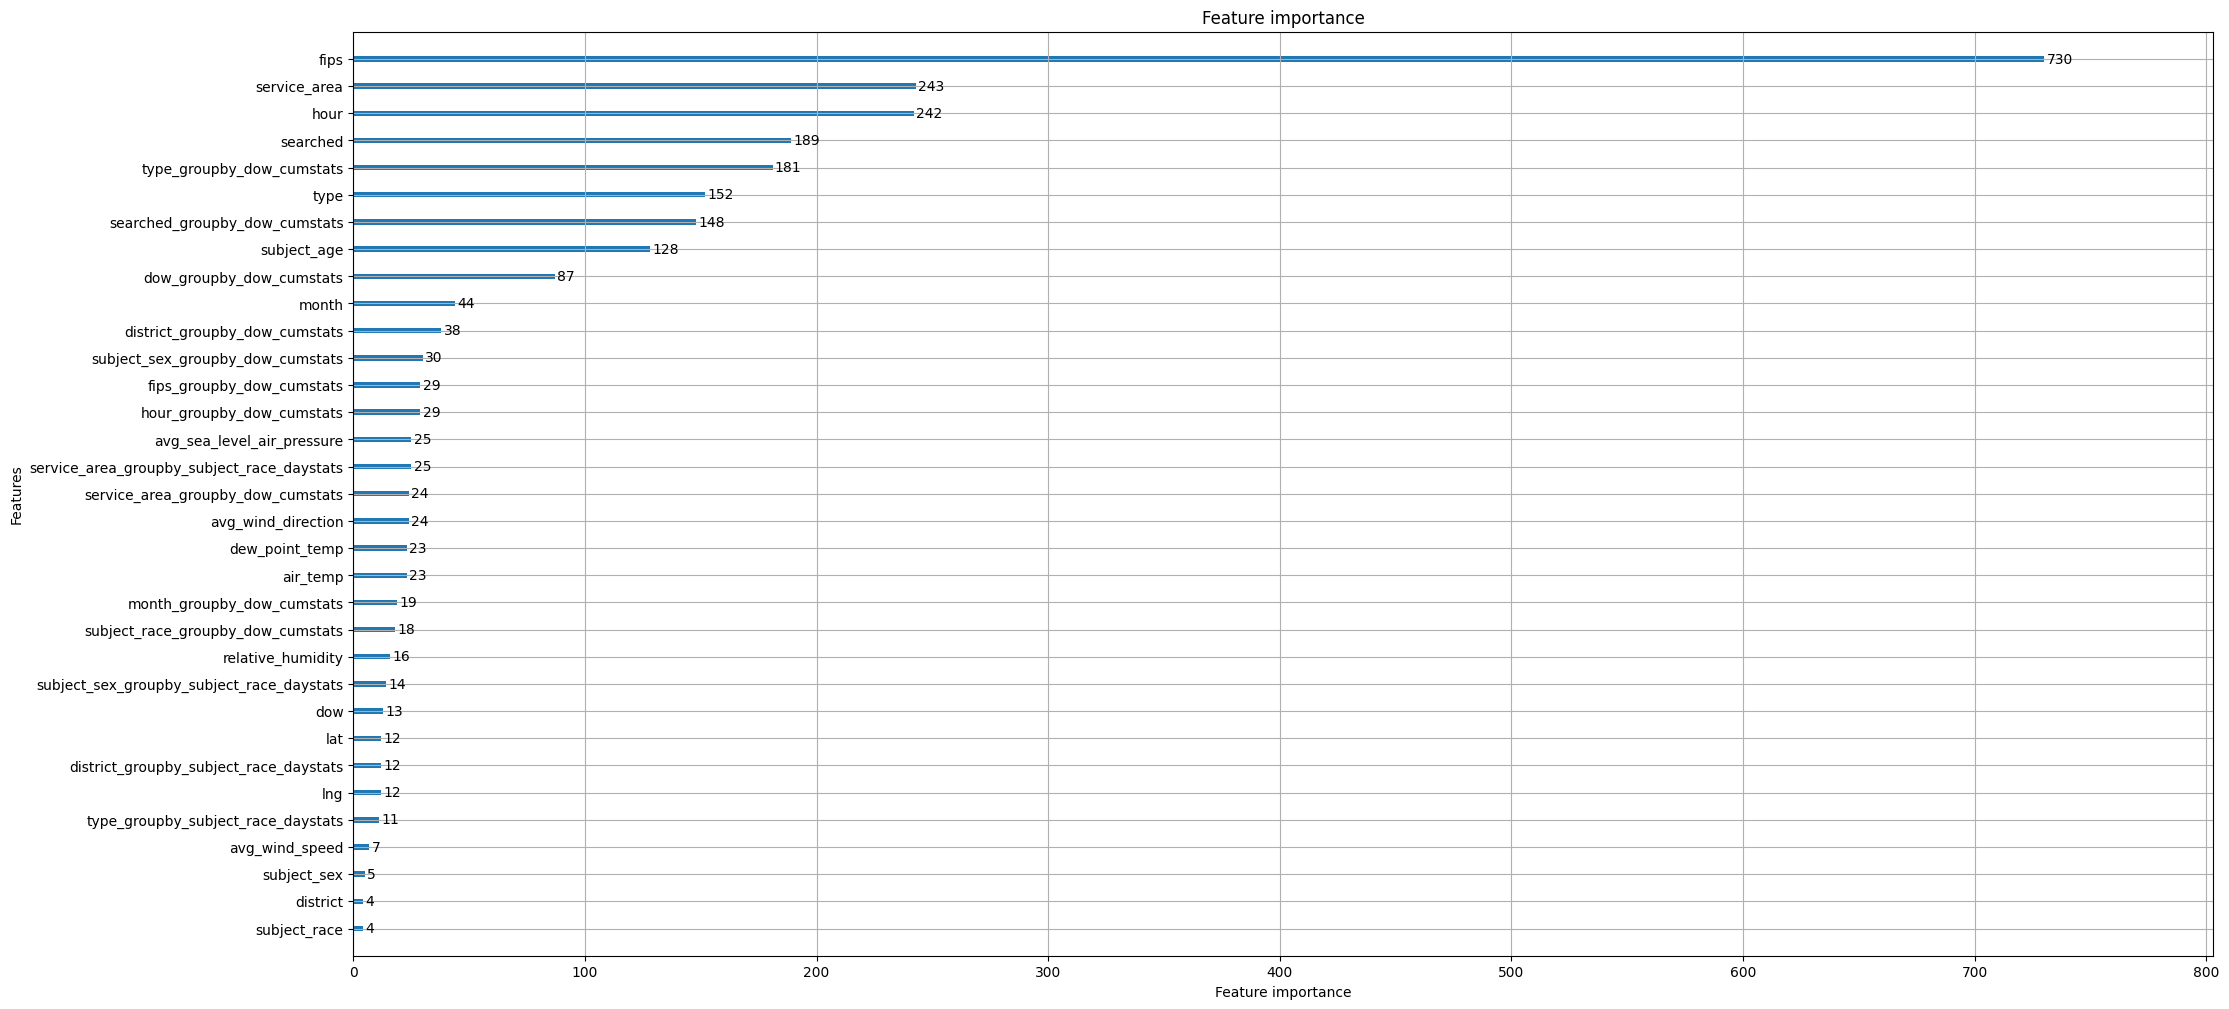

In [281]:
fig,ax = plt.subplots(figsize=(24,12))
lgb.plot_importance(bst['cvbooster'].boosters[-1],ax=ax)
fig.savefig('importance.png')

In [255]:
|## test with dummy strategy
print(f"searched arrested")
predict_all(test_df[label],test_df['searched'])
# print(f"searched arrested")
# predict_all(test_df[label],test_df['searched'])

searched arrested
f1 score: 63.09, recall score: 86.10, precision score: 49.79


In [ ]:
print(f"searched arrested")
predict_all(new_results[label],new_results['searched'])

searched arrested
f1 score: 70.81, recall score: 78.59, precision score: 64.43
